In [1]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import ast
import librosa.display

from IPython.display import Audio
import random
from scipy.stats import zscore

## Data Collection and Structure

In [2]:
# 1. Set paths
"""
Checking the number of files per genre
"""
data_folder = "data"      # folder containing genre subfolders
genres = os.listdir(data_folder)

print("Number of files per genre:")
for genre in genres:
    genre_path = os.path.join(data_folder, genre)
    # Only count .wav files
    num_files = len([f for f in os.listdir(genre_path) if f.endswith('.wav')])
    print(f"{genre}: {num_files} files")


Number of files per genre:
blues: 100 files
classical: 100 files
country: 100 files
disco: 100 files
hiphop: 100 files
jazz: 100 files
metal: 100 files
pop: 100 files
reggae: 100 files
rock: 100 files


In [ ]:
"""
Checking the basic metadata availability
Since .wav files don’t have CSV metadata by default, we can extract basic info like:
duration, sample rate, and number of channels to check consistency:
"""
for genre in genres:
    genre_path = os.path.join(data_folder, genre)
    for file in os.listdir(genre_path):
        if file.endswith('.wav'):
            file_path = os.path.join(genre_path, file)
            try:
                y, sr = librosa.load(file_path, sr=None)  # loading audio
                duration = librosa.get_duration(y=y, sr=sr)
                #print(f"{genre}/{file} → Duration: {duration:.2f}s, Sample rate: {sr}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

In [4]:
"""
Check label consistency
Since folders represent genres, check for:
Unexpected folder names
Any empty folders
"""

for genre in genres:
    genre_path = os.path.join(data_folder, genre)
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    if len(files) == 0:
        print(f"Warning: {genre} folder is empty!")


In [5]:
"""
Building a summary table: It’s useful to have a pandas DataFrame for summarizing the dataset:
"""

summary = []

for genre in genres:
    genre_path = os.path.join(data_folder, genre)
    for file in os.listdir(genre_path):
        if file.endswith('.wav'):
            file_path = os.path.join(genre_path, file)
            try:
                y, sr = librosa.load(file_path, sr=None)
                duration = librosa.get_duration(y=y, sr=sr)
                summary.append([genre, file, duration, sr])
            except:
                summary.append([genre, file, None, None])

# Creating a Summary of Dataset Dataframe not Actual Dataframe
df_summary = pd.DataFrame(summary, columns=['Genre', 'Filename', 'Duration', 'SampleRate'])
print(df_summary.head())
print(df_summary.groupby('Genre')['Filename'].count())
print(df_summary.describe())

C:\Users\Aman\AppData\Local\Temp\ipykernel_3156\3929007130.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)


   Genre         Filename   Duration  SampleRate
0  blues  blues.00000.wav  30.013333     22050.0
1  blues  blues.00001.wav  30.013333     22050.0
2  blues  blues.00002.wav  30.013333     22050.0
3  blues  blues.00003.wav  30.013333     22050.0
4  blues  blues.00004.wav  30.013333     22050.0
Genre
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: Filename, dtype: int64
         Duration  SampleRate
count  999.000000       999.0
mean    30.024071     22050.0
std      0.080951         0.0
min     29.931973     22050.0
25%     30.000181     22050.0
50%     30.013333     22050.0
75%     30.013333     22050.0
max     30.648889     22050.0


# Data Cleaning

In [6]:
"""
Verifying File Integrity
"""

corrupt_files = []

for genre in genres:
    genre_path = os.path.join(data_folder, genre)
    for file in os.listdir(genre_path):
        if file.endswith('.wav'):
            file_path = os.path.join(genre_path, file)
            try:
                y, sr = librosa.load(file_path, sr=None)
            except Exception as e:
                corrupt_files.append(file_path)

print("Corrupt files:", corrupt_files)

C:\Users\Aman\AppData\Local\Temp\ipykernel_3156\1756570878.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
C:\Users\Aman\.conda\envs\mllab\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Corrupt files: ['data\\jazz\\jazz.00054.wav']


In [7]:
"""
Check for Duplicates
Duplicate audio files can bias your model.
We can check for duplicates by filename or by audio fingerprinting (optional, advanced).
"""

all_files = []
duplicates = []

for genre in genres:
    genre_path = os.path.join(data_folder, genre)
    for file in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file)
        if file_path in all_files:
            duplicates.append(file_path)
        else:
            all_files.append(file_path)

print("Duplicate files:", duplicates)
#print("ALL Files: ", all_files)

Duplicate files: []


In [8]:
"""
Checking for the Noise or Silence: For very short silent segments, we will remove or flag them.
"""
low_energy_files = []
clipped_files = []

def is_clipped(y, threshold=0.99, ratio=0.001):
    num_clipped = ((y >= threshold) | (y <= -threshold)).sum()
    return (num_clipped / len(y)) > ratio


for genre in genres:
    print(f"Processing folder: {genre}")  # debug line to see progress
    genre_path = os.path.join(data_folder, genre)
    
    for file in os.listdir(genre_path):
        if file.endswith('.wav'):
            file_path = os.path.join(genre_path, file)
            try:
                # Load audio
                y, sr = librosa.load(file_path, sr=None)
                
                # Compute RMS energy
                rms = librosa.feature.rms(y=y).mean()
                if rms < 0.01:
                    print(f"Low-energy file: {file_path}")
                    low_energy_files.append(file_path)
                
                # Clipping check
                if is_clipped(y):
                    print(f"Clipped file: {file_path}")
                    clipped_files.append(file_path)
            
            except Exception as e:
                print(f"Cannot read file: {file_path} → {e}")
                if file_path not in corrupt_files:
                    corrupt_files.append(file_path)
            except BaseException:  # catch any other unexpected errors
                print(f"Cannot read file (unknown error): {file_path}")
                if file_path not in corrupt_files:
                    corrupt_files.append(file_path)


print("\nTotal low-energy files:", len(low_energy_files))
if low_energy_files:
    print("List of low-energy files:")
    for f in low_energy_files:
        print(f)


print("\nTotal clipped files:", len(clipped_files))
if clipped_files:
    print("Clipped files:")
    for f in clipped_files:
        print(f)

print("\nTotal unreadable/corrupt files:", len(corrupt_files))
if corrupt_files:
    print("List of unreadable/corrupt files:")
    for f in corrupt_files:
        print(f)


"""
Summary:
Low-energy files: 7 files in classical genre (too quiet, RMS < 0.01).
Clipped files: 27 files across hiphop, pop, reggae (signal hitting maximum amplitude).
Corrupt/unreadable files: 1 file in jazz (jazz.00054.wav).

All other audio files are ready for feature extraction.
"""

Processing folder: blues
Processing folder: classical
Low-energy file: data\classical\classical.00016.wav
Low-energy file: data\classical\classical.00019.wav
Low-energy file: data\classical\classical.00032.wav
Low-energy file: data\classical\classical.00047.wav
Low-energy file: data\classical\classical.00050.wav
Low-energy file: data\classical\classical.00078.wav
Low-energy file: data\classical\classical.00080.wav
Processing folder: country
Processing folder: disco
Processing folder: hiphop
Clipped file: data\hiphop\hiphop.00003.wav
Clipped file: data\hiphop\hiphop.00004.wav
Clipped file: data\hiphop\hiphop.00009.wav
Clipped file: data\hiphop\hiphop.00019.wav
Clipped file: data\hiphop\hiphop.00038.wav
Clipped file: data\hiphop\hiphop.00076.wav
Clipped file: data\hiphop\hiphop.00078.wav
Processing folder: jazz


C:\Users\Aman\AppData\Local\Temp\ipykernel_3156\586428030.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
C:\Users\Aman\.conda\envs\mllab\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Cannot read file: data\jazz\jazz.00054.wav → 
Processing folder: metal
Processing folder: pop
Clipped file: data\pop\pop.00035.wav
Clipped file: data\pop\pop.00039.wav
Clipped file: data\pop\pop.00052.wav
Clipped file: data\pop\pop.00054.wav
Clipped file: data\pop\pop.00055.wav
Clipped file: data\pop\pop.00057.wav
Clipped file: data\pop\pop.00059.wav
Clipped file: data\pop\pop.00060.wav
Clipped file: data\pop\pop.00061.wav
Clipped file: data\pop\pop.00062.wav
Clipped file: data\pop\pop.00068.wav
Clipped file: data\pop\pop.00070.wav
Clipped file: data\pop\pop.00074.wav
Clipped file: data\pop\pop.00077.wav
Clipped file: data\pop\pop.00078.wav
Clipped file: data\pop\pop.00088.wav
Clipped file: data\pop\pop.00089.wav
Clipped file: data\pop\pop.00095.wav
Processing folder: reggae
Clipped file: data\reggae\reggae.00065.wav
Clipped file: data\reggae\reggae.00086.wav
Processing folder: rock

Total low-energy files: 7
List of low-energy files:
data\classical\classical.00016.wav
data\classical\c

'\nSummary:\nLow-energy files: 7 files in classical genre (too quiet, RMS < 0.01).\nClipped files: 27 files across hiphop, pop, reggae (signal hitting maximum amplitude).\nCorrupt/unreadable files: 1 file in jazz (jazz.00054.wav).\n\nAll other audio files are ready for feature extraction.\n'

In [ ]:
"""
Summary of Cleaning Steps Done
- Verified audio files are readable → removed corrupt files.
- Checked for duplicates → removed or renamed them.
- Normalized duration → all files are exactly 30s.
- Checked for very quiet/silent audio → flagged for review.
- Sample rate uniformity → all 22050 Hz, no action needed.
"""

In [9]:
print(corrupt_files)
print(low_energy_files)
print(clipped_files)

['data\\jazz\\jazz.00054.wav']
['data\\classical\\classical.00016.wav', 'data\\classical\\classical.00019.wav', 'data\\classical\\classical.00032.wav', 'data\\classical\\classical.00047.wav', 'data\\classical\\classical.00050.wav', 'data\\classical\\classical.00078.wav', 'data\\classical\\classical.00080.wav']
['data\\hiphop\\hiphop.00003.wav', 'data\\hiphop\\hiphop.00004.wav', 'data\\hiphop\\hiphop.00009.wav', 'data\\hiphop\\hiphop.00019.wav', 'data\\hiphop\\hiphop.00038.wav', 'data\\hiphop\\hiphop.00076.wav', 'data\\hiphop\\hiphop.00078.wav', 'data\\pop\\pop.00035.wav', 'data\\pop\\pop.00039.wav', 'data\\pop\\pop.00052.wav', 'data\\pop\\pop.00054.wav', 'data\\pop\\pop.00055.wav', 'data\\pop\\pop.00057.wav', 'data\\pop\\pop.00059.wav', 'data\\pop\\pop.00060.wav', 'data\\pop\\pop.00061.wav', 'data\\pop\\pop.00062.wav', 'data\\pop\\pop.00068.wav', 'data\\pop\\pop.00070.wav', 'data\\pop\\pop.00074.wav', 'data\\pop\\pop.00077.wav', 'data\\pop\\pop.00078.wav', 'data\\pop\\pop.00088.wav', '

## Visualizing before extracting features

In [10]:
# Prepare metadata
metadata = []

for genre in genres:
    genre_path = os.path.join(data_folder, genre)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)
            try:
                y, sr = librosa.load(file_path, sr=None)
                duration = librosa.get_duration(y=y, sr=sr)
            except:
                duration = None  # if file is unreadable
            metadata.append({
                'genre': genre,
                'filename': file,
                'duration': duration,
                'sample_rate': sr if 'sr' in locals() else None
            })

df_metadata = pd.DataFrame(metadata)

C:\Users\Aman\AppData\Local\Temp\ipykernel_3156\3217575412.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)


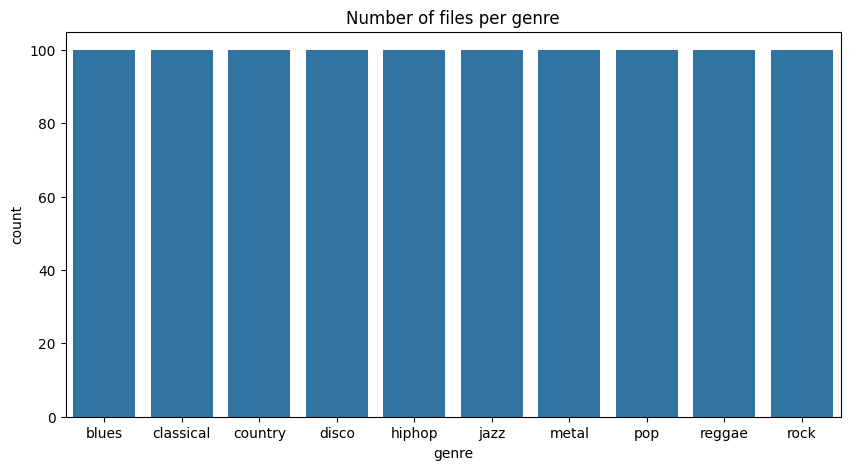

In [11]:
# Class Distribution:
plt.figure(figsize=(10,5))
sns.countplot(data=df_metadata, x='genre')
plt.title("Number of files per genre")
plt.show()

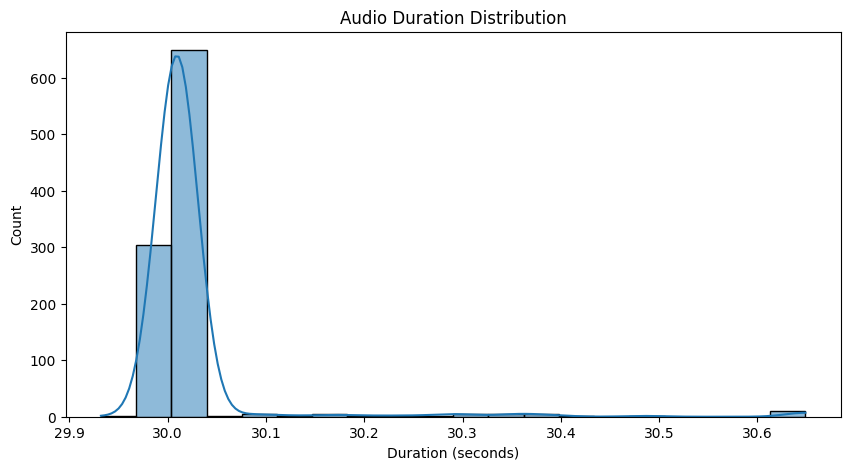

In [12]:
# Duration Distribution: 
plt.figure(figsize=(10,5))
sns.histplot(df_metadata['duration'], bins=20, kde=True)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.show()

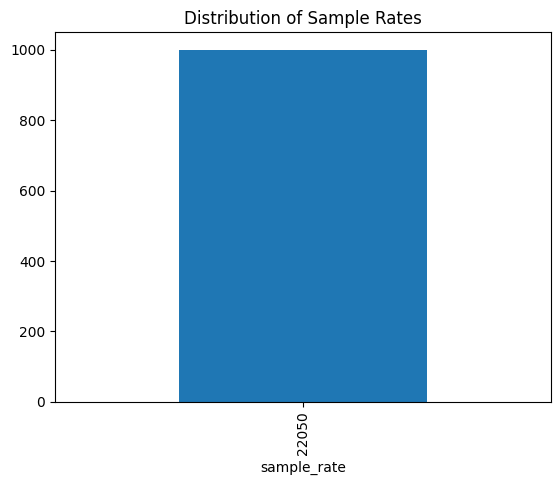

In [13]:
# Sample Rate Check: 
df_metadata['sample_rate'].value_counts().plot(kind='bar')
plt.title("Distribution of Sample Rates")
plt.show()

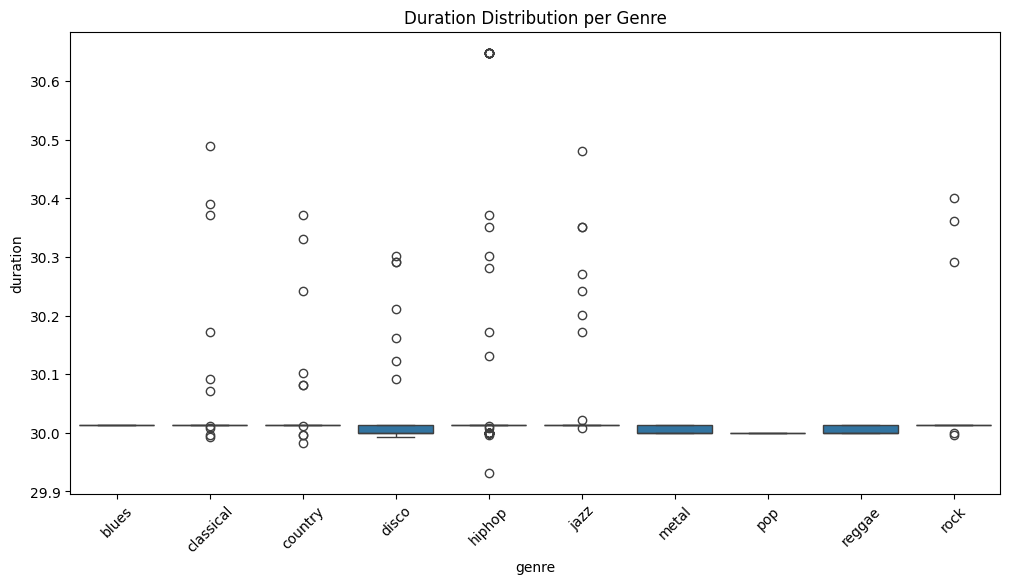

In [14]:
# Duration Per Genre:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_metadata, x='genre', y='duration')
plt.title("Duration Distribution per Genre")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Quick Audio Spot Checks:
# Pick a random file
sample_file = random.choice(df_metadata['filename'].tolist())
sample_genre = df_metadata[df_metadata['filename'] == sample_file]['genre'].values[0]
file_path = os.path.join(data_folder, sample_genre, sample_file)

# Print info
print(f"Playing file: {sample_file} | Genre: {sample_genre}")

# Play audio
Audio(file_path)


Playing file: classical.00003.wav | Genre: classical


In [66]:
# Final Summary Statistics Table
df_metadata.groupby('genre')[['duration']].describe()

duration                                                            \
             count       mean           std        min        25%        50%   
genre                                                                          
blues        100.0  30.013333  7.141223e-15  30.013333  30.013333  30.013333   
classical    100.0  30.027941  7.182078e-02  29.992925  30.013333  30.013333   
country      100.0  30.023935  5.396425e-02  29.981859  30.013333  30.013333   
disco        100.0  30.019719  5.702136e-02  29.992925  30.000181  30.000181   
hiphop       100.0  30.089263  1.986732e-01  29.931973  30.013333  30.013333   
jazz          99.0  30.033311  7.732181e-02  30.007982  30.013333  30.013333   
metal        100.0  30.004390  6.165968e-03  30.000181  30.000181  30.000181   
pop          100.0  30.000181  0.000000e+00  30.000181  30.000181  30.000181   
reggae       100.0  30.005574  6.501143e-03  30.000181  30.000181  30.000181   
rock         100.0  30.023156  5.852619e-02  29.995828  30.013333  30.013333   

                                 
                 75%        max  
genre                            
blues      30.013333  30.013333  
classical  30.013333  30.488980  
country    30.013333  30.370975  
disco      30.013333  30.301134  
hiphop     30.013333  30.648889  
jazz       30.013333  30.480726  
metal      30.013333  30.013333  
pop        30.000181  30.000181  
reggae     30.013333  30.013333  
rock       30.013333  30.400907

## Feature Extraction:

In [67]:
output_csv = "audio_features.csv"
skip_files = set(corrupt_files)

def extract_features(file_path):
    """
    Takes file path as input and returns the extracted features in numerical form
    """
    
    y, sr = librosa.load(file_path, sr=None)
    features = {}

    # Duration
    features['length'] = librosa.get_duration(y=y, sr=sr)

    # Chroma STFT
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_stft_mean'] = chroma.mean()
    features['chroma_stft_var'] = chroma.var()

    # RMS
    rms = librosa.feature.rms(y=y)
    features['rms_mean'] = rms.mean()
    features['rms_var'] = rms.var()

    # Spectral centroid & bandwidth
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_centroid_mean'] = centroid.mean()
    features['spectral_centroid_var'] = centroid.var()
    features['spectral_bandwidth_mean'] = bandwidth.mean()
    features['spectral_bandwidth_var'] = bandwidth.var()

    # Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['rolloff_mean'] = rolloff.mean()
    features['rolloff_var'] = rolloff.var()

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features['zero_crossing_rate_mean'] = zcr.mean()
    features['zero_crossing_rate_var'] = zcr.var()

    # Harmonic & Tonnetz (harmony/perceptr)
    y_harm = librosa.effects.harmonic(y)
    features['harmony_mean'] = y_harm.mean()
    features['harmony_var'] = y_harm.var()
    tonnetz = librosa.feature.tonnetz(y=y_harm, sr=sr)
    features['perceptr_mean'] = tonnetz.mean()
    features['perceptr_var'] = tonnetz.var()

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = float(tempo[0])

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc{i+1}_mean'] = mfccs[i].mean()
        features[f'mfcc{i+1}_var'] = mfccs[i].var()

    return features


In [25]:
# Looping over all folders and files without Corrupted included
feature_list = []

genres = os.listdir(data_folder)
for genre in genres:
    genre_folder = os.path.join(data_folder, genre)
    for file_name in tqdm(os.listdir(genre_folder), desc=genre):
        if file_name.endswith(".wav"):
            file_path = os.path.join(genre_folder, file_name)
            
            # Skip corrupt or low-energy files
            if file_path in skip_files:
                continue
                
            try:
                feats = extract_features(file_path)
                feats['label'] = genre
                feats['filename'] = file_name

                # Reorder so filename and label come first
                ordered_feats = {
                    'filename': feats['filename'],
                    'label': feats['label'],
                    **{k: v for k, v in feats.items() if k not in ['filename', 'label']}
                }
                
                feature_list.append(feats)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

rock: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.47s/it]


In [26]:
# Saving to CSV
features_df = pd.DataFrame(feature_list)
features_df.to_csv(output_csv, index=False)
print(f"Feature extraction complete. CSV saved to {output_csv}")

Feature extraction complete. CSV saved to audio_features.csv


In [16]:
df = pd.read_csv("audio_features.csv")

In [17]:
cols = ['filename', 'label'] + [c for c in df.columns if c not in ['filename', 'label']]
df = df[cols]
df.to_csv("audio_features.csv", index=False)

In [18]:
df = pd.read_csv("audio_features.csv")
df['tempo'] = df['tempo'].apply(lambda x: ast.literal_eval(x)[0])

In [19]:
print(df.head(5))
print(df['label'].value_counts())
print("Unique audio files:", df['filename'].nunique())

          filename  label     length  chroma_stft_mean  chroma_stft_var  \
0  blues.00000.wav  blues  30.013333          0.350129         0.088772   
1  blues.00001.wav  blues  30.013333          0.340849         0.094976   
2  blues.00002.wav  blues  30.013333          0.363538         0.085257   
3  blues.00003.wav  blues  30.013333          0.404854         0.093999   
4  blues.00004.wav  blues  30.013333          0.308526         0.087843   

   rms_mean   rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.130184  0.002828             1784.122641            129745.4844   
1  0.095908  0.002373             1530.261767            375915.5088   
2  0.175473  0.002751             1552.832481            156471.0109   
3  0.141040  0.006348             1070.153418            184366.0094   
4  0.091501  0.002305             1835.128513            343249.4957   

   spectral_bandwidth_mean  ...  mfcc16_mean  mfcc16_var  mfcc17_mean  \
0              2002.412407  ...     0.75170

In [20]:
df.columns

Index(['filename', 'label', 'length', 'chroma_stft_mean', 'chroma_stft_var',
       'rms_mean', 'rms_var', 'spectral_centroid_mean',
       'spectral_centroid_var', 'spectral_bandwidth_mean',
       'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var',
       'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean',
       'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean',
       'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var',
       'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean',
       'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var',
       'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean',
       'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var',
       'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean',
       'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var',
       'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 

## Completed Steps
1. Dataset Loading & Structure Check  
Loaded .wav files from 10 genre folders.  
Checked number of files per genre → mostly balanced (100 per genre, one missing in jazz).  
Checked metadata consistency: duration, sample rate, filenames.  
  
2. Data Cleaning / Integrity Checks  
Corrupt/unreadable files: Detected 1 unreadable file (jazz.00054.wav) → added to corrupt_files list.  
Low-energy files: Detected 7 files (all in classical) → added to low_energy_files list.  
Clipped files: Detected 27 files (mostly hiphop, pop, reggae) → added to clipped_files list.  
Purpose: flag potential problematic files without deleting them and remove corrupted file from df.  

3. Pre-feature EDA / Metadata Analysis  
Computed descriptive statistics for duration (mean, std, min/max, percentiles).  
Found most songs ~30s; small variation in classical, hiphop, jazz.  
Plotted genre distribution, duration boxplots, file sizes, low-energy/clipped counts per genre.  
Sampled random audio files for qualitative inspection.  

4. Feature Extraction  
Extracted audio features using librosa:  
Time-domain: RMS, Zero-Crossing Rate, Harmonic, Tempo  
Frequency-domain: Chroma STFT, Spectral Centroid, Bandwidth, Rolloff, Tonnetz  
MFCCs: 20 coefficients (mean & variance)  

Saved extracted features in a structured DataFrame (df_features) including filename and genre labels.

In [21]:
print(df.shape)
df.info()
df.isna().sum()

(999, 60)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 999 non-null    object 
 1   label                    999 non-null    object 
 2   length                   999 non-null    float64
 3   chroma_stft_mean         999 non-null    float64
 4   chroma_stft_var          999 non-null    float64
 5   rms_mean                 999 non-null    float64
 6   rms_var                  999 non-null    float64
 7   spectral_centroid_mean   999 non-null    float64
 8   spectral_centroid_var    999 non-null    float64
 9   spectral_bandwidth_mean  999 non-null    float64
 10  spectral_bandwidth_var   999 non-null    float64
 11  rolloff_mean             999 non-null    float64
 12  rolloff_var              999 non-null    float64
 13  zero_crossing_rate_mean  999 non-null    float64
 14  zero_crossing_ra

filename                   0
label                      0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean    

In [22]:
df.describe().T

count          mean           std           min  \
length                   999.0  3.002407e+01  8.095083e-02     29.931973   
chroma_stft_mean         999.0  3.788196e-01  8.168353e-02      0.171896   
chroma_stft_var          999.0  8.634743e-02  7.742332e-03      0.044571   
rms_mean                 999.0  1.308265e-01  6.567110e-02      0.005270   
rms_var                  999.0  3.051438e-03  3.634863e-03      0.000004   
spectral_centroid_mean   999.0  2.202419e+03  7.160770e+02    570.349904   
spectral_centroid_var    999.0  4.698072e+05  4.009029e+05   7996.725156   
spectral_bandwidth_mean  999.0  2.242764e+03  5.265170e+02    900.409298   
spectral_bandwidth_var   999.0  1.369773e+05  9.640983e+04  11146.734320   
rolloff_mean             999.0  4.572915e+03  1.575067e+03    749.740169   
rolloff_var              999.0  1.843581e+06  1.425086e+06  14951.350020   
zero_crossing_rate_mean  999.0  1.036511e-01  4.182380e-02      0.021697   
zero_crossing_rate_var   999.0  2.988522e-03  3.024097e-03      0.000044   
harmony_mean             999.0 -3.661808e-04  1.684834e-03     -0.026058   
harmony_var              999.0  1.253151e-02  1.165552e-02      0.000049   
perceptr_mean            999.0  1.255844e-02  3.239996e-02     -0.142334   
perceptr_var             999.0  2.282287e-02  1.765949e-02      0.000575   
tempo                    999.0  1.192932e+02  2.808695e+01     58.726918   
mfcc1_mean               999.0 -1.445302e+02  1.002635e+02   -552.158600   
mfcc1_var                999.0  3.749698e+03  2.770517e+03    175.288450   
mfcc2_mean               999.0  9.953122e+01  3.133161e+01     -1.471577   
mfcc2_var                999.0  7.066448e+02  4.391685e+02     93.098690   
mfcc3_mean               999.0 -8.928433e+00  2.169761e+01    -89.865090   
mfcc3_var                999.0  4.683205e+02  2.870549e+02     35.535614   
mfcc4_mean               999.0  3.630572e+01  1.666554e+01    -18.756536   
mfcc4_var                999.0  2.204806e+02  1.162278e+02     34.387690   
mfcc5_mean               999.0 -1.152302e+00  1.222631e+01    -38.911594   
mfcc5_var                999.0  1.744126e+02  1.007279e+02     29.895018   
mfcc6_mean               999.0  1.464281e+01  1.184252e+01    -28.404940   
mfcc6_var                999.0  1.272384e+02  6.846841e+01     20.805113   
mfcc7_mean               999.0 -5.133780e+00  9.944871e+00    -32.941410   
mfcc7_var                999.0  1.163864e+02  5.836557e+01     29.036852   
mfcc8_mean               999.0  1.012723e+01  1.046642e+01    -24.918982   
mfcc8_var                999.0  8.819791e+01  4.103383e+01     22.371315   
mfcc9_mean               999.0 -7.000893e+00  8.286531e+00    -31.642633   
mfcc9_var                999.0  8.854918e+01  3.949751e+01     25.869972   
mfcc10_mean              999.0  7.733659e+00  7.940846e+00    -12.048641   
mfcc10_var               999.0  8.173411e+01  3.672098e+01     19.228132   
mfcc11_mean              999.0 -6.025727e+00  6.819911e+00    -28.051817   
mfcc11_var               999.0  7.553743e+01  3.813665e+01     21.398330   
mfcc12_mean              999.0  4.476135e+00  6.718115e+00    -15.802279   
mfcc12_var               999.0  6.866263e+01  3.262981e+01     18.670560   
mfcc13_mean              999.0 -4.798487e+00  6.173437e+00    -27.536580   
mfcc13_var               999.0  6.786325e+01  3.316452e+01     17.281326   
mfcc14_mean              999.0  1.783511e+00  5.011052e+00    -12.606835   
mfcc14_var               999.0  6.476796e+01  3.445522e+01     14.149703   
mfcc15_mean              999.0 -3.874770e+00  4.874144e+00    -17.537825   
mfcc15_var               999.0  6.286942e+01  3.391804e+01      9.737433   
mfcc16_mean              999.0  1.150304e+00  4.580871e+00    -15.693880   
mfcc16_var               999.0  6.073125e+01  3.379699e+01      9.200760   
mfcc17_mean              999.0 -3.965957e+00  4.551857e+00    -17.237364   
mfcc17_var               999.0  6.262095e+01  3.348560e+01     13.870569 

## EDA

## Analysis on Features

Generating all high-quality EDA plots...


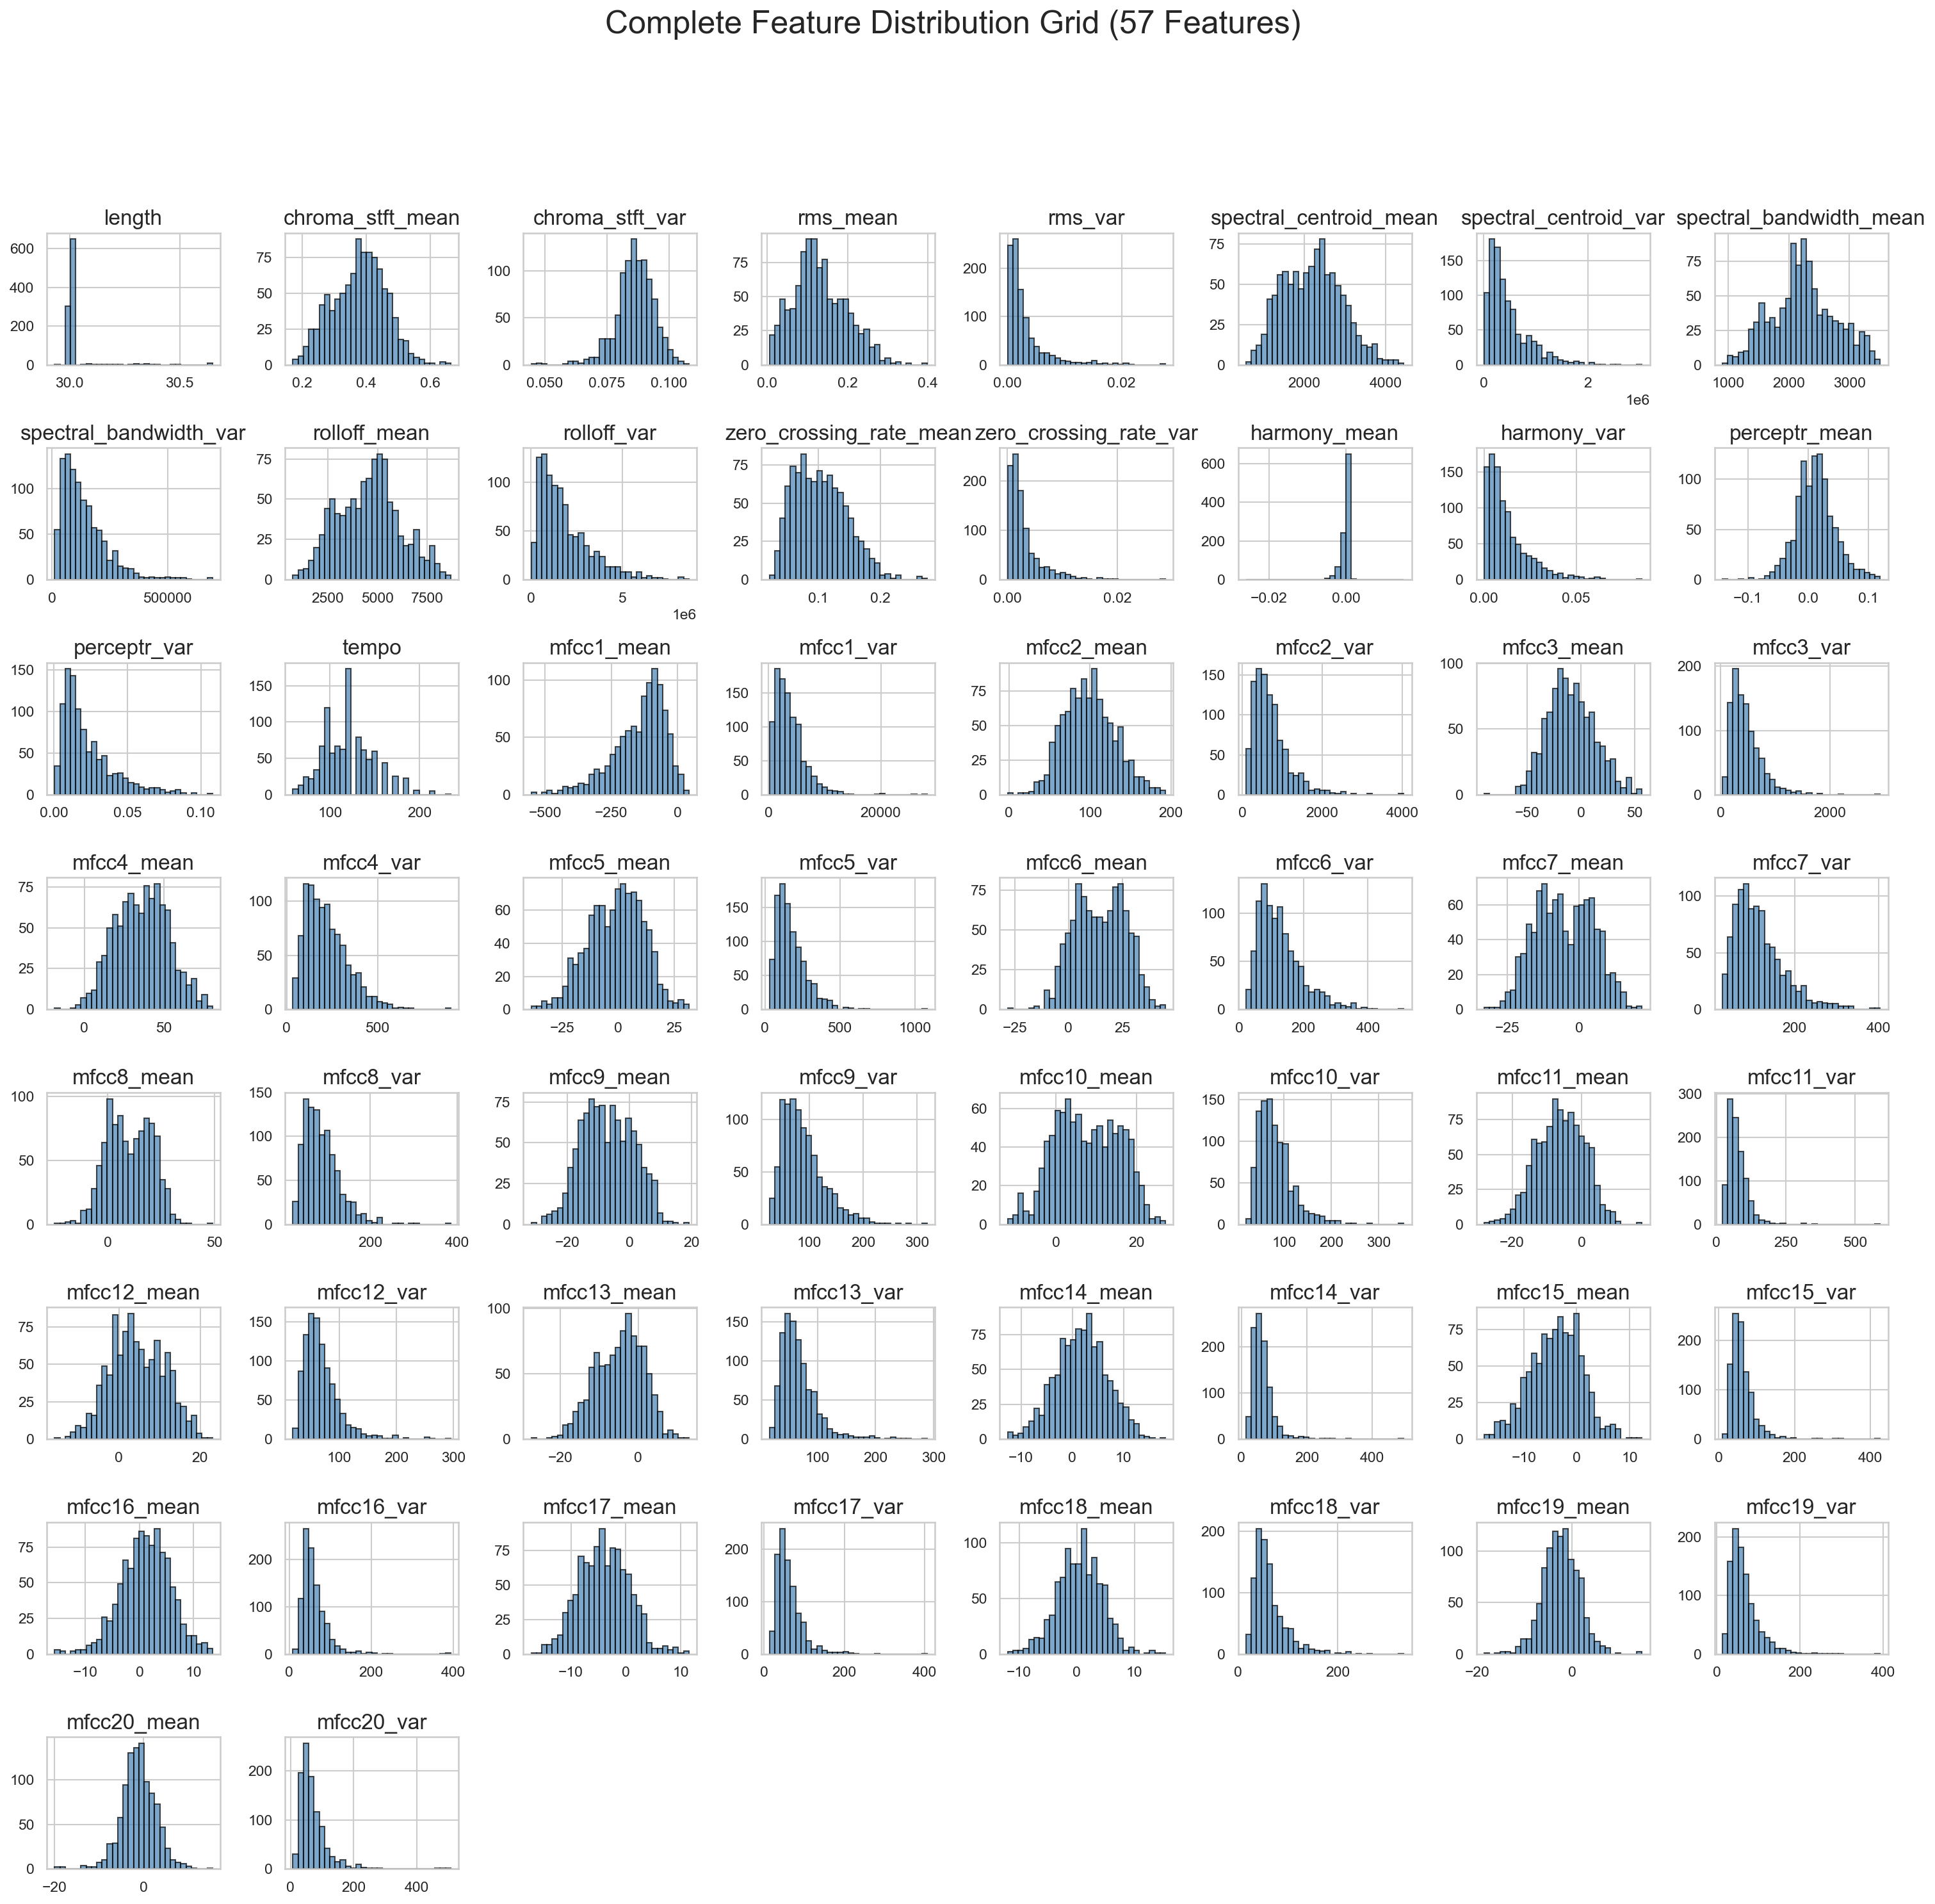

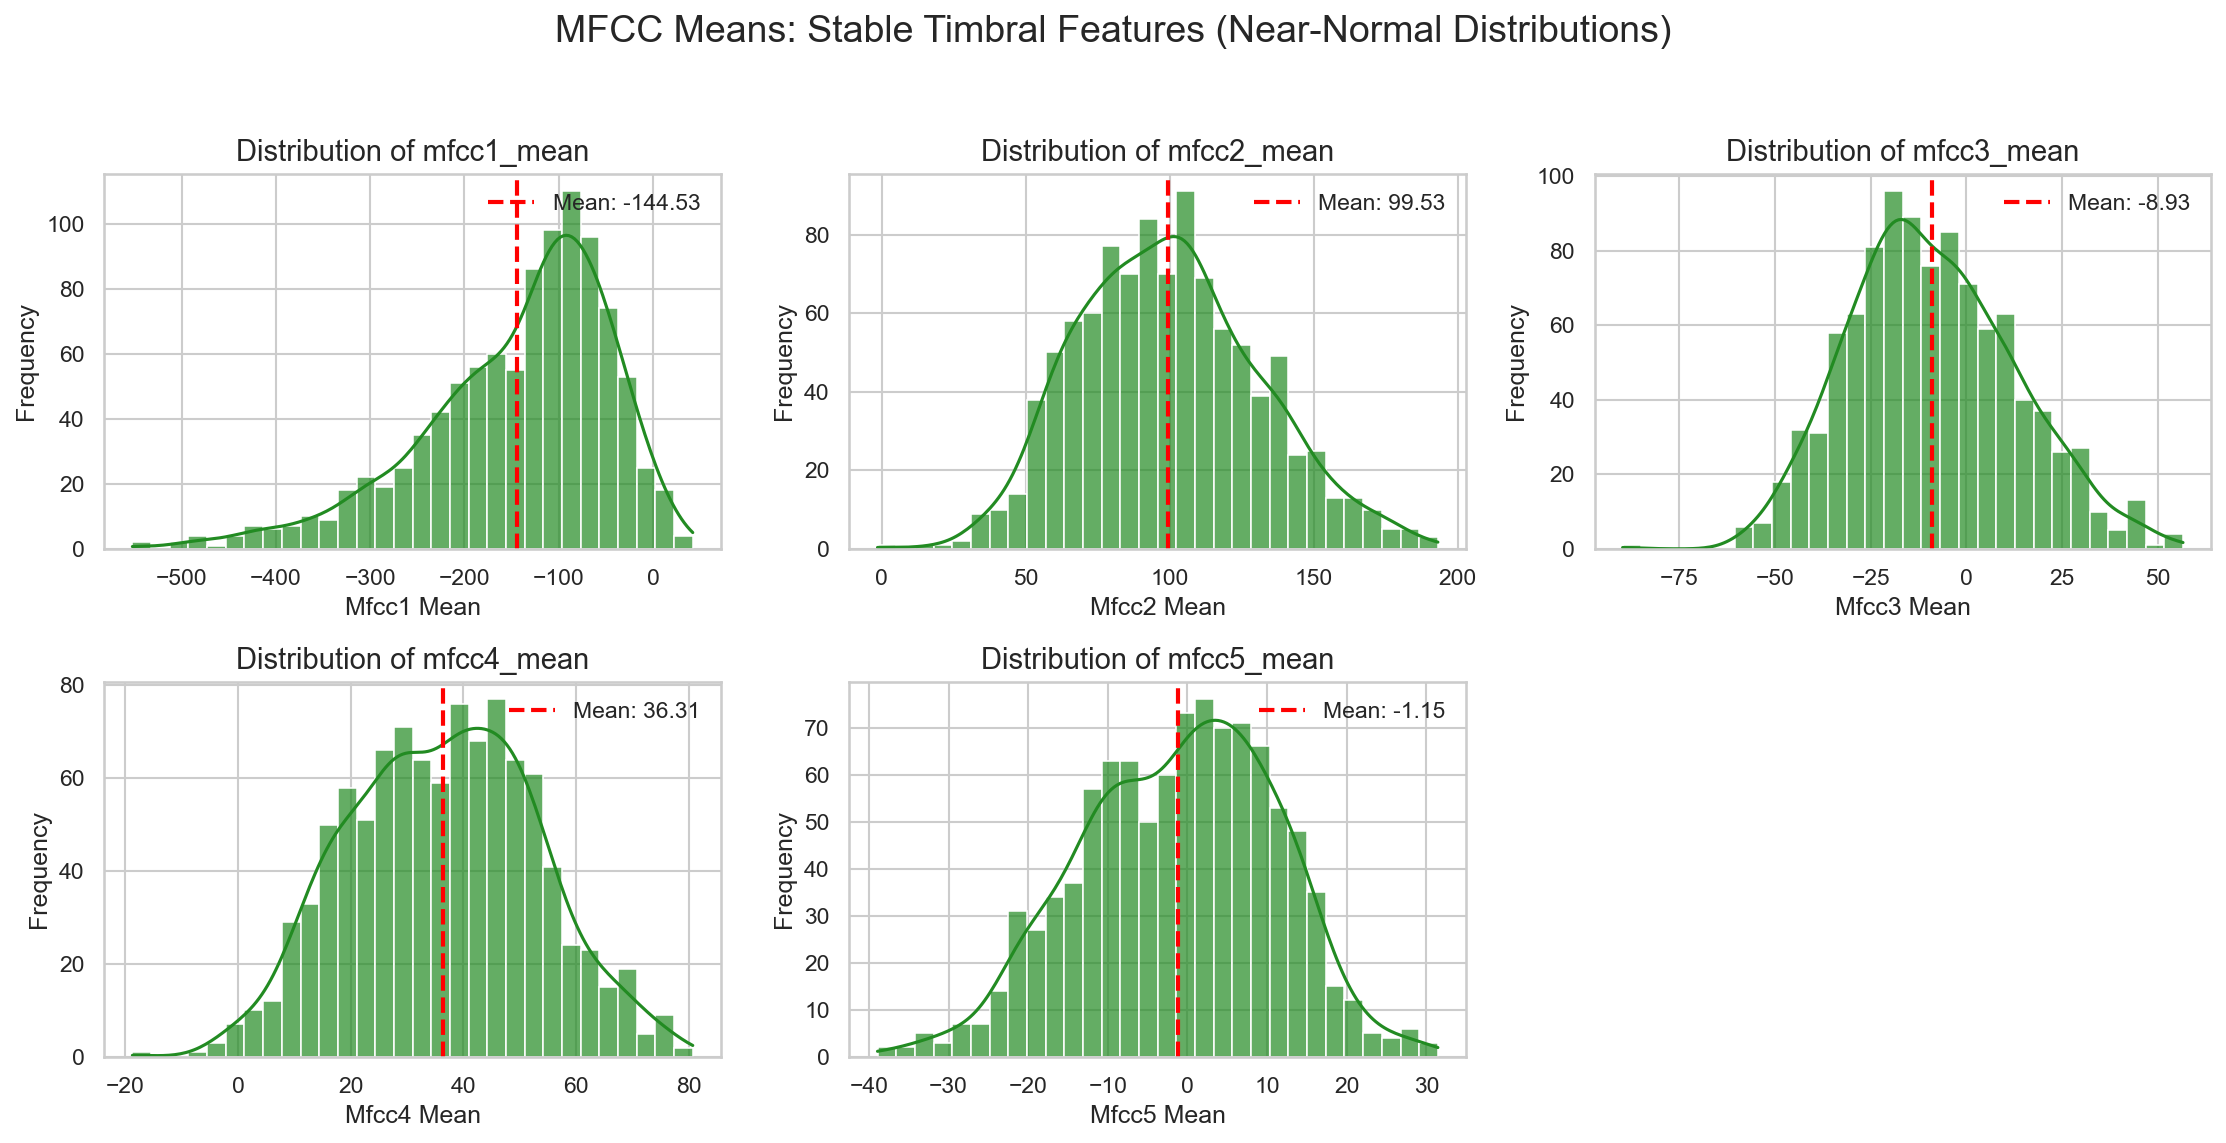

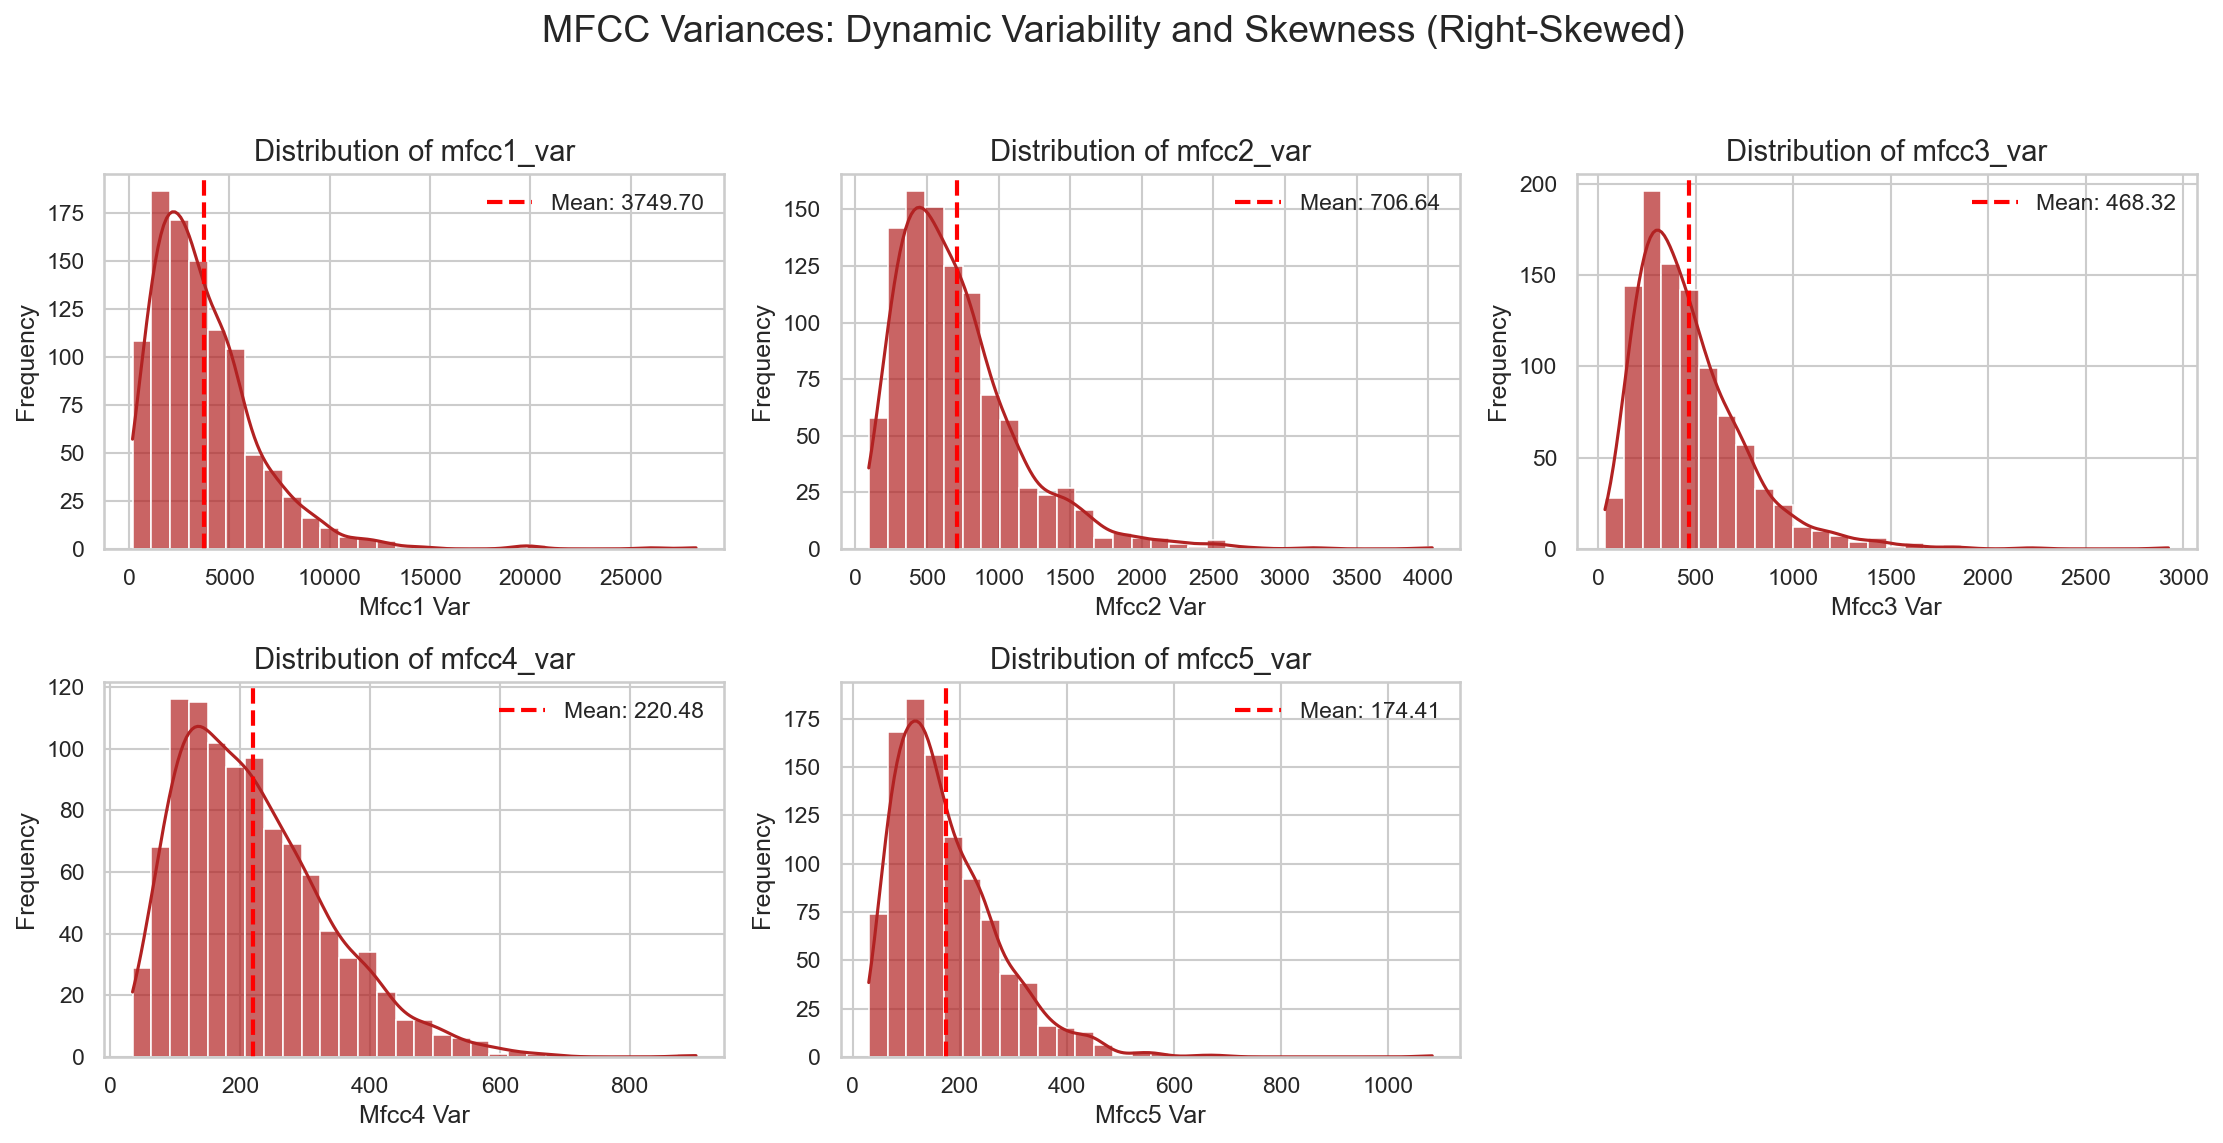

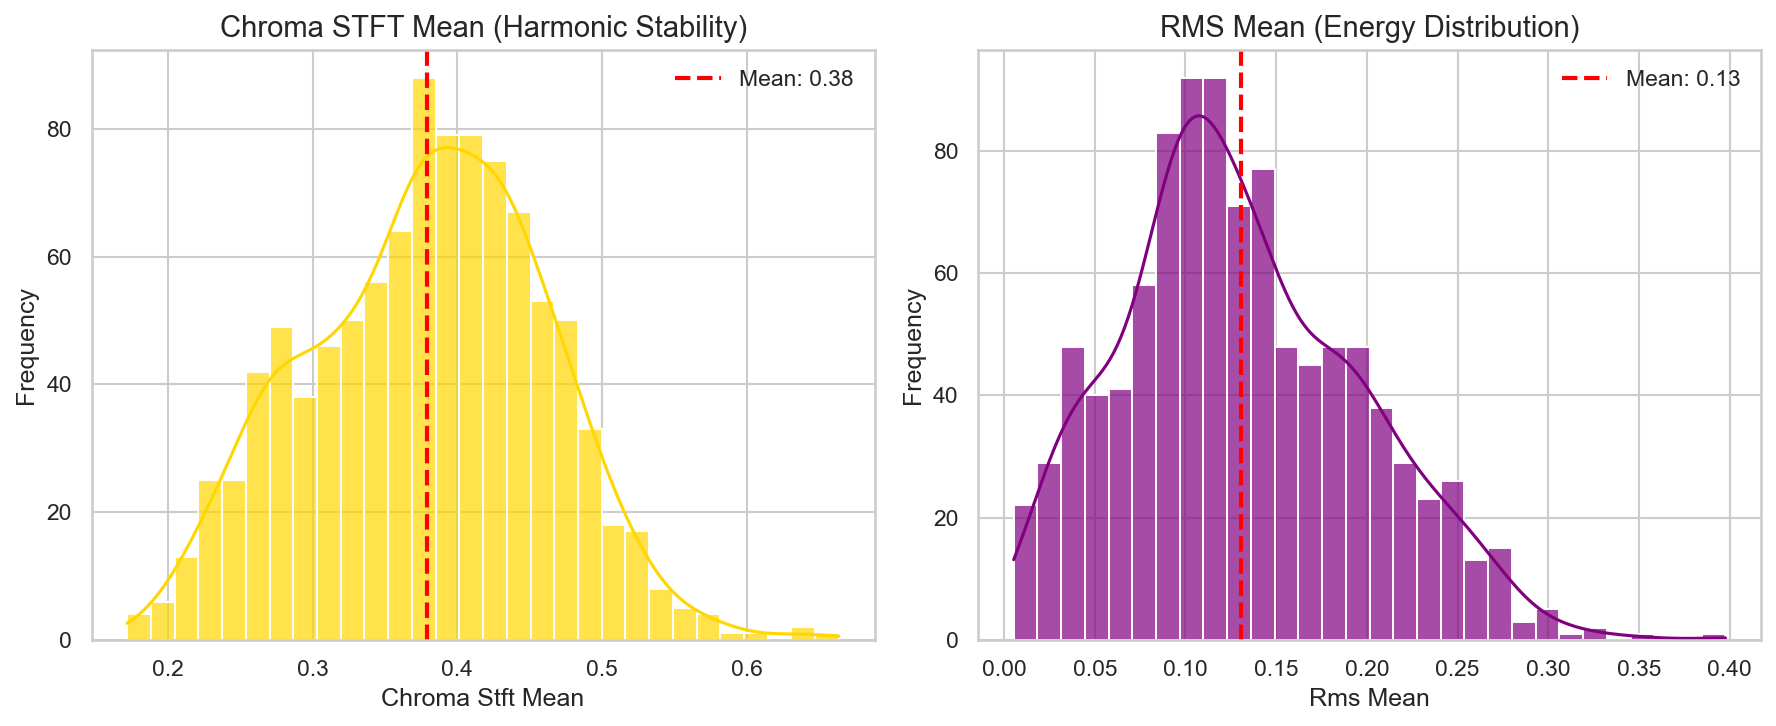

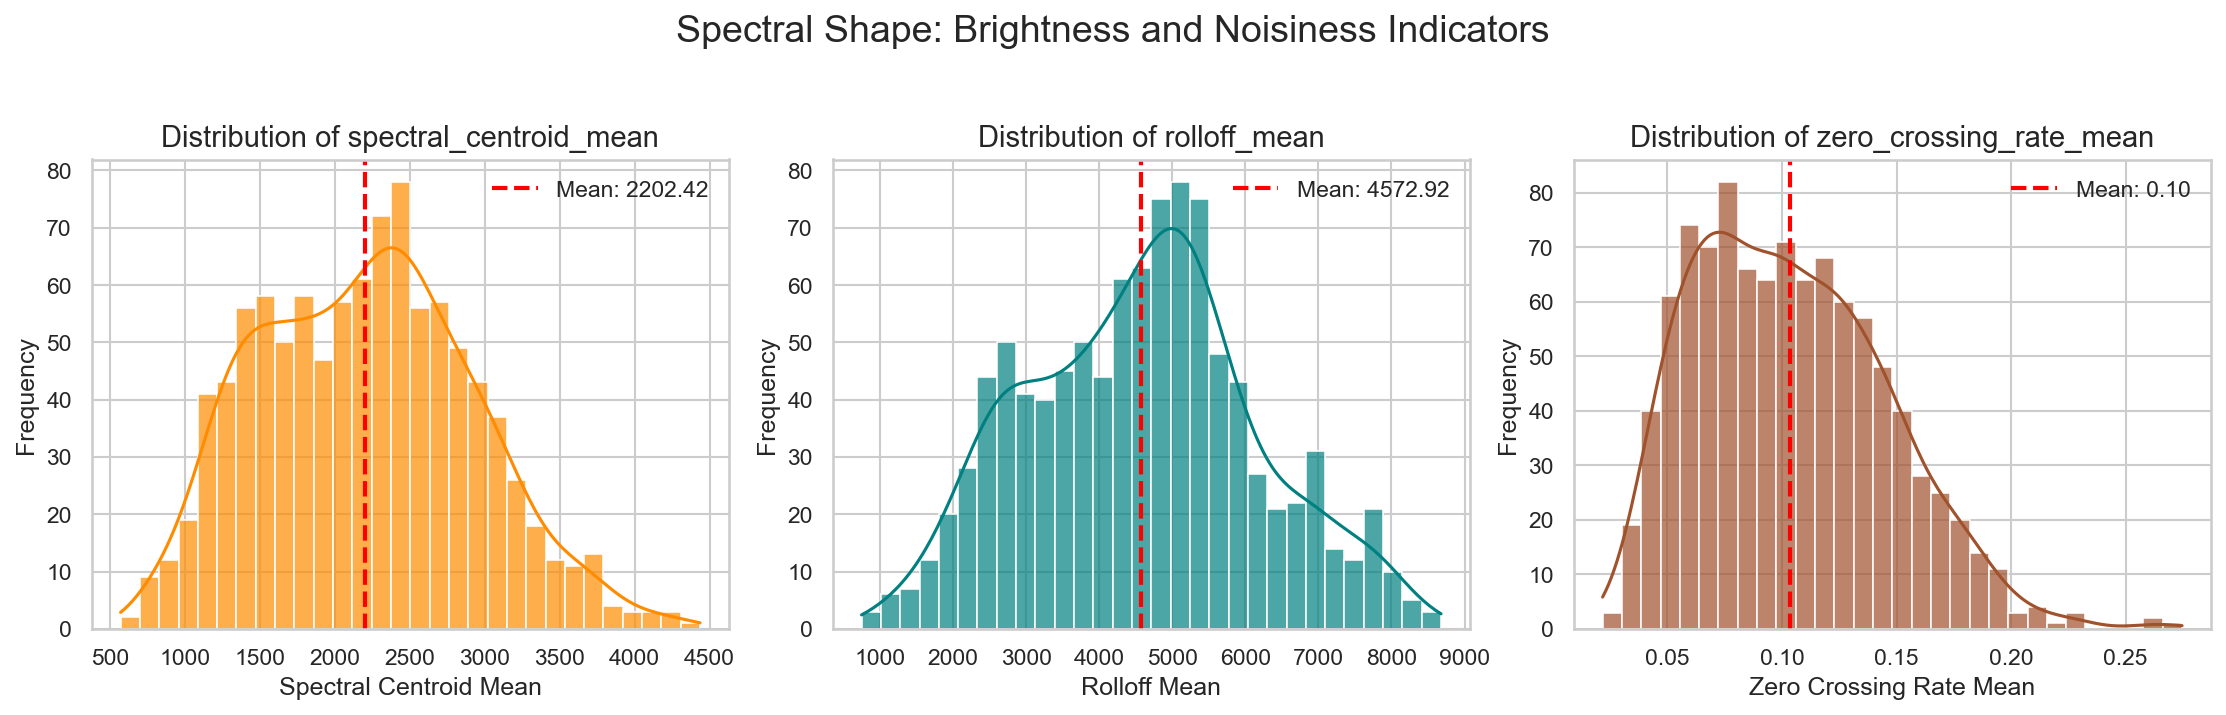

Plots generated and saved as PNG files with high resolution.


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# setting a theme
sns.set_theme(style="whitegrid", palette="muted")

# 150 DPI for on-screen viewing, 300 DPI for high-quality save
plt.rcParams['figure.dpi'] = 150 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# === Helper Function for Histograms with Annotations === #
def create_hist_plot(data, column, color, ax):
    """Generates a high-quality histogram with KDE and Mean line."""
    
    # Use histplot for KDE and improved aesthetics (Step 2)
    sns.histplot(data[column], kde=True, color=color, alpha=0.7, edgecolor='white', bins=30, ax=ax)
    
    # Add Mean line (Step 4)
    mean_val = data[column].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    # Set titles and labels (Step 3)
    ax.set_title(f"Distribution of {column}", fontsize=14)
    ax.set_xlabel(column.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.legend(loc='upper right')

# =========================================================
# === PLOTTING FUNCTIONS GROUPED BY SLIDE TOPIC ===========
# =========================================================

# ---- 1. Full Histogram Grid (Background for Slide 1) ---
def plot_full_grid(df):
    """Generates the full 57-feature histogram grid."""
    num_cols = df.select_dtypes(include='number').columns
    
    # Using pandas hist function but with enhanced matplotlib settings
    df[num_cols].hist(figsize=(20, 20), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    
    plt.suptitle("Complete Feature Distribution Grid (57 Features)", fontsize=24, y=1.02)
    
    # Use tight_layout (Step 3)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save at high quality (Step 5)
    plt.savefig('Plots/Full_Feature_Grid_High_Res.png')
    plt.show()

# --- 2. Dataset Integrity (Foreground for Slide 1) ---
def plot_integrity(df):
    """Plots the distribution of the 'length' feature."""
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    
    # Length is highly concentrated, use a small bin count
    sns.histplot(df['length'], bins=5, color='darkgreen', kde=False, edgecolor='black', ax=ax)
    
    ax.set_title("Audio Segment Length Distribution (Integrity Check)", fontsize=14)
    ax.set_xlabel("Length (seconds)")
    ax.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.savefig('Plots/Dataset_Integrity_Length.png')
    plt.show()

# --- 3. Timbral Stability: MFCC Means (Slide 2) ---
def plot_mfcc_means(df):
    """Plots the distribution of the first 5 MFCC means."""
    mfcc_mean_cols = [f'mfcc{i}_mean' for i in range(1, 6)]
    plt.figure(figsize=(15, 8))
    
    for i, col in enumerate(mfcc_mean_cols, 1):
        ax = plt.subplot(2, 3, i)
        create_hist_plot(df, col, color='forestgreen', ax=ax)
        
    plt.suptitle("MFCC Means: Stable Timbral Features (Near-Normal Distributions)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('Plots/MFCC_Means_Stability.png')
    plt.show()

# --- 4. Dynamic Variability: MFCC Variances (Slide 3) ---
def plot_mfcc_vars(df):
    """Plots the distribution of the first 5 MFCC variances."""
    mfcc_var_cols = [f'mfcc{i}_var' for i in range(1, 6)]
    plt.figure(figsize=(15, 8))
    
    for i, col in enumerate(mfcc_var_cols, 1):
        ax = plt.subplot(2, 3, i)
        create_hist_plot(df, col, color='firebrick', ax=ax)
        
    plt.suptitle("MFCC Variances: Dynamic Variability and Skewness (Right-Skewed)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('Plots/MFCC_Variances_Skewness.png')
    plt.show()

# --- 5. Harmonic & Energy Analysis (Slide 4) ---
def plot_harmonic_energy(df):
    """Plots the distribution of Chroma Mean and RMS Mean."""
    plt.figure(figsize=(12, 5))
    
    ax1 = plt.subplot(1, 2, 1)
    create_hist_plot(df, 'chroma_stft_mean', color='gold', ax=ax1)
    ax1.set_title("Chroma STFT Mean (Harmonic Stability)", fontsize=14)
    
    ax2 = plt.subplot(1, 2, 2)
    create_hist_plot(df, 'rms_mean', color='purple', ax=ax2)
    ax2.set_title("RMS Mean (Energy Distribution)", fontsize=14)
    
    plt.tight_layout()
    plt.savefig('Plots/Chroma_RMS_Analysis.png')
    plt.show()

# --- 6. Spectral Shape & Texture (Slide 5) ---
def plot_spectral_shape(df):
    """Plots the distribution of Spectral Centroid, Rolloff, and ZCR means with unique colors."""
    
    features = ['spectral_centroid_mean', 'rolloff_mean', 'zero_crossing_rate_mean']
    
    # Define a distinct color palette for the three features
    # These colors (Orange, Teal, Brown) are visually separate from each other
    colors = ['darkorange', 'teal', 'sienna']
    
    plt.figure(figsize=(15, 5))
    
    for i, feat in enumerate(features, 1):
        ax = plt.subplot(1, 3, i)
        
        # Use the corresponding color from the 'colors' list
        create_hist_plot(df, feat, color=colors[i-1], ax=ax)
        
    plt.suptitle("Spectral Shape: Brightness and Noisiness Indicators", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('Plots/Spectral_Shape_Analysis.png')
    plt.show()
# =========================================================
# === CALL FUNCTIONS TO GENERATE ALL SLIDE PLOTS ==========
# =========================================================
print("Generating all high-quality EDA plots...")

# Slide 1 Visuals
plot_full_grid(df) # The large background grid
plot_mfcc_means(df)
plot_mfcc_vars(df)
plot_harmonic_energy(df)
plot_spectral_shape(df)

print("Plots generated and saved as PNG files with high resolution.")

## Correlation of Features

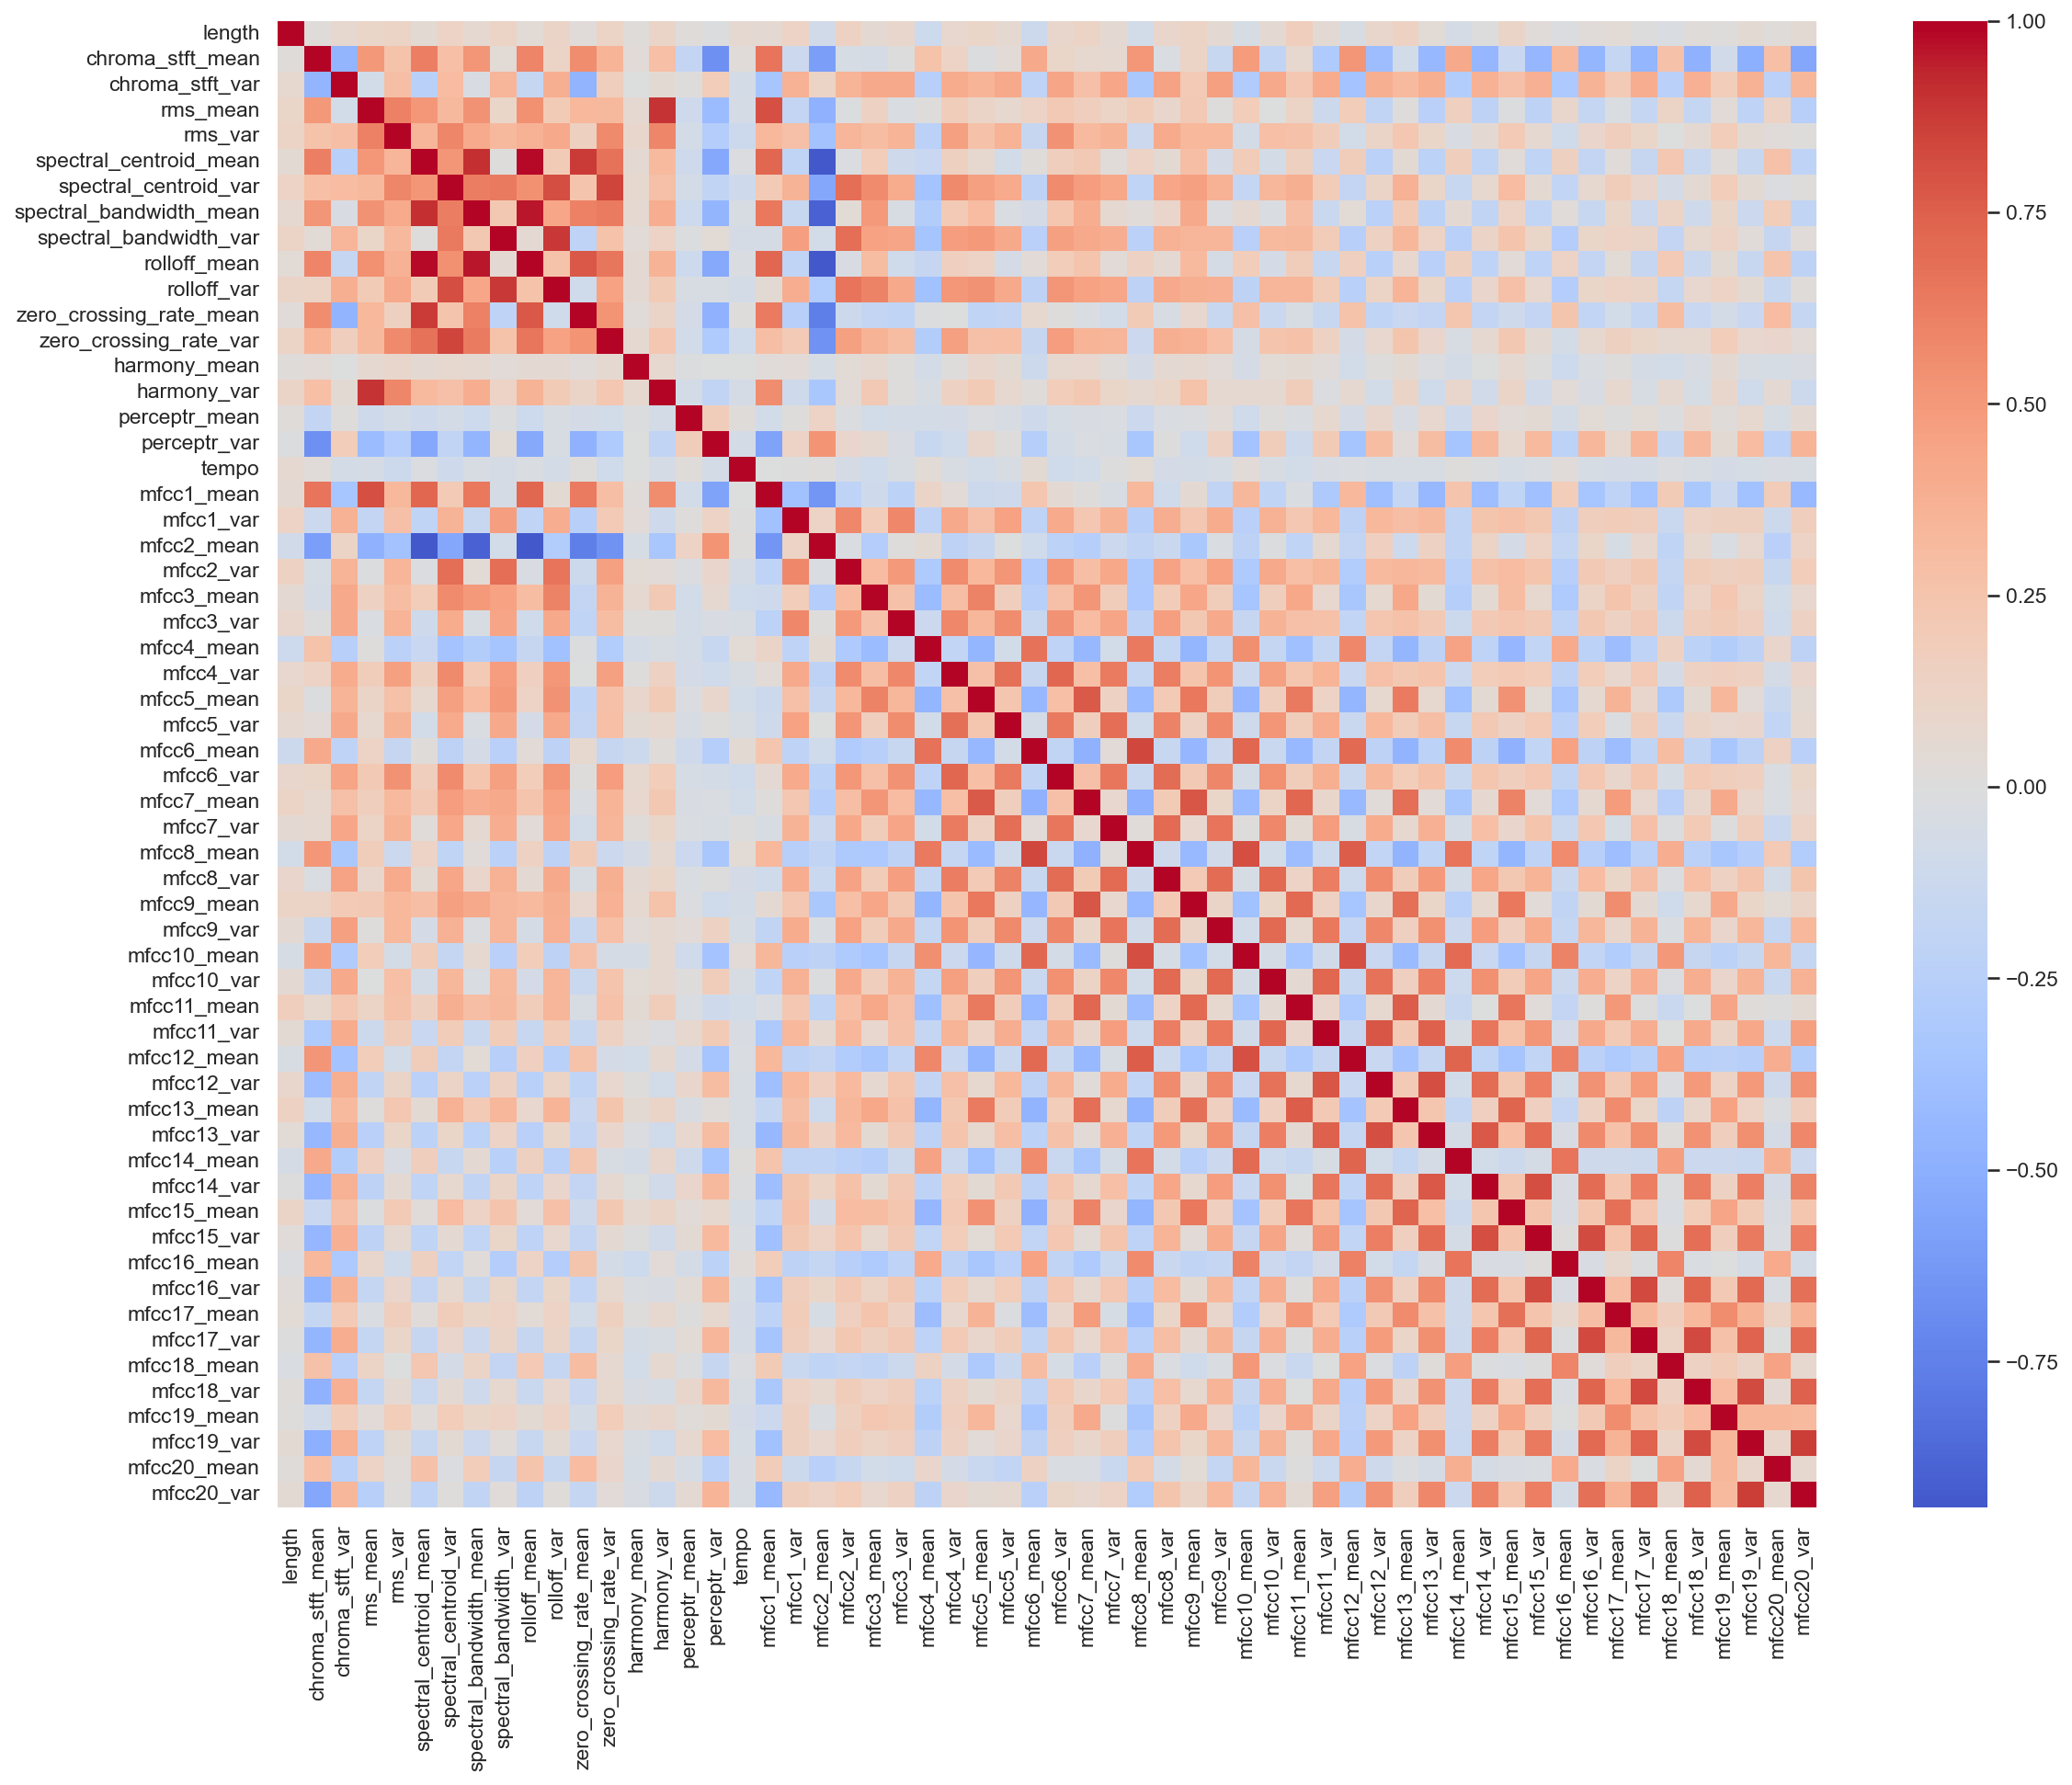

In [43]:
# Correlation Matrix:
num_cols = df.select_dtypes(include='number').columns
corr = df[num_cols].corr()

plt.figure(figsize=(18,14))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.savefig('Plots/Correlation.png')
plt.show()

In [27]:
#Highly Correlated Pairs:
high_corr = corr.abs().unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1]   #Removing the diagonal
high_corr[high_corr > 0.85].head(20)


rolloff_mean             spectral_centroid_mean     0.979621
spectral_centroid_mean   rolloff_mean               0.979621
rolloff_mean             spectral_bandwidth_mean    0.956278
spectral_bandwidth_mean  rolloff_mean               0.956278
mfcc2_mean               spectral_centroid_mean     0.940176
spectral_centroid_mean   mfcc2_mean                 0.940176
mfcc2_mean               rolloff_mean               0.934289
rolloff_mean             mfcc2_mean                 0.934289
spectral_centroid_mean   spectral_bandwidth_mean    0.904512
spectral_bandwidth_mean  spectral_centroid_mean     0.904512
mfcc2_mean               spectral_bandwidth_mean    0.896706
spectral_bandwidth_mean  mfcc2_mean                 0.896706
rms_mean                 harmony_var                0.893937
harmony_var              rms_mean                   0.893937
rolloff_var              spectral_bandwidth_var     0.884917
spectral_bandwidth_var   rolloff_var                0.884917
spectral_centroid_mean  

## Pairplots:

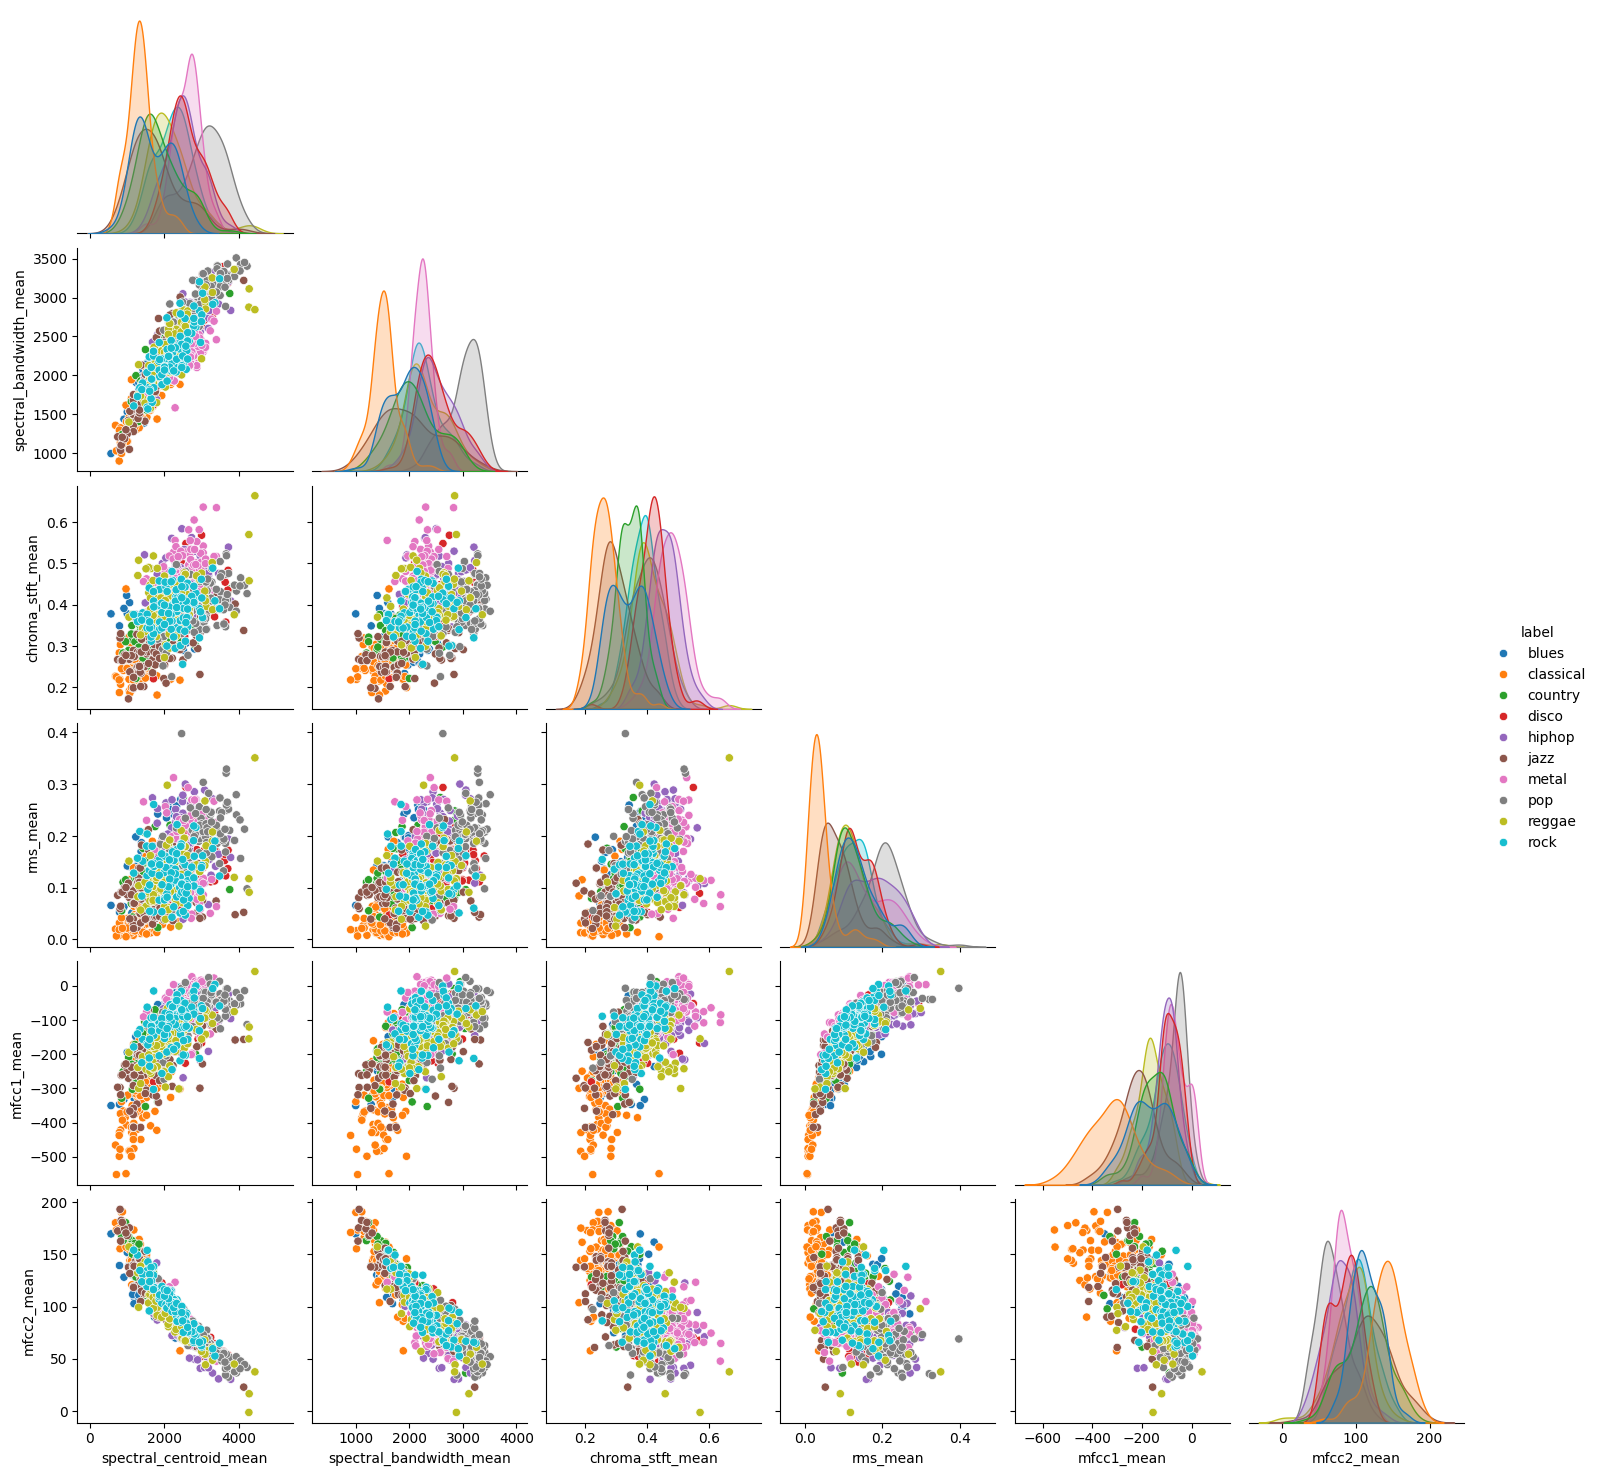

In [120]:

subset = df[['spectral_centroid_mean','spectral_bandwidth_mean',
              'chroma_stft_mean', 'rms_mean','mfcc1_mean','mfcc2_mean','label']]

sns.pairplot(subset, hue="label", corner=True)
plt.savefig('Plots/pairplot.png')
plt.show()

## Audio Visualizations

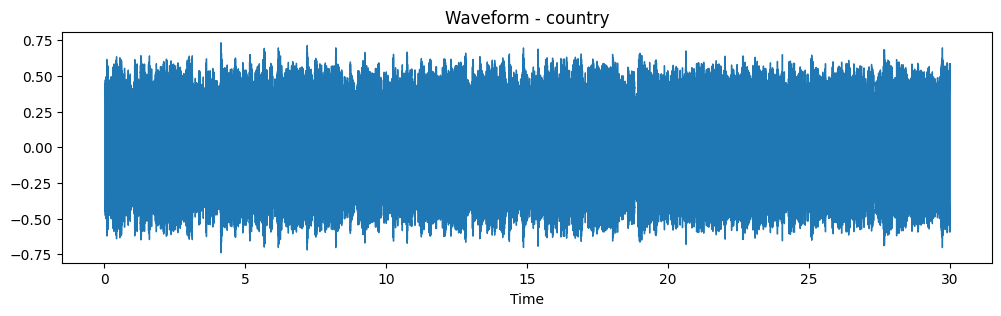

In [11]:
paths = []
for idx, row in df.iterrows():
    file_path = os.path.join("data", row['label'], row['filename'])
    paths.append(file_path)

df['path'] = paths

# Waveform:
sample_row = df.sample(1, random_state=40).iloc[0]
y, sr = librosa.load(sample_row['path'], sr=None)
plt.figure(figsize=(12,3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - {sample_row['label']}")
plt.show()

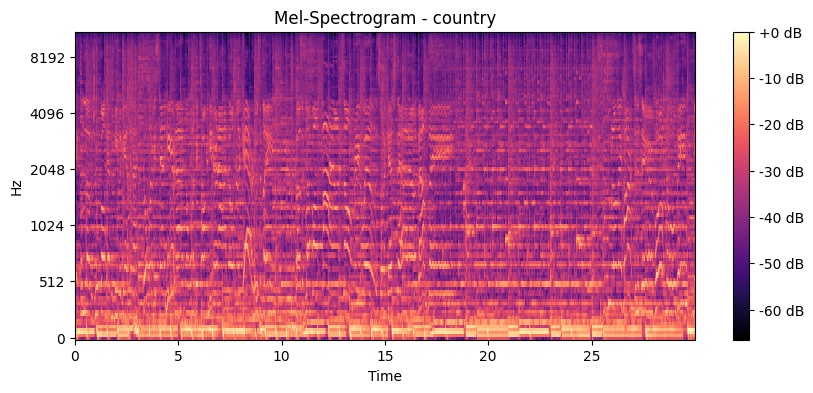

In [34]:
# Mel-Spectogram:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)   # use y=... and sr=...
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.f dB")
plt.title(f"Mel-Spectrogram - {sample_row['label']}")
plt.show()

## Feature Visualization

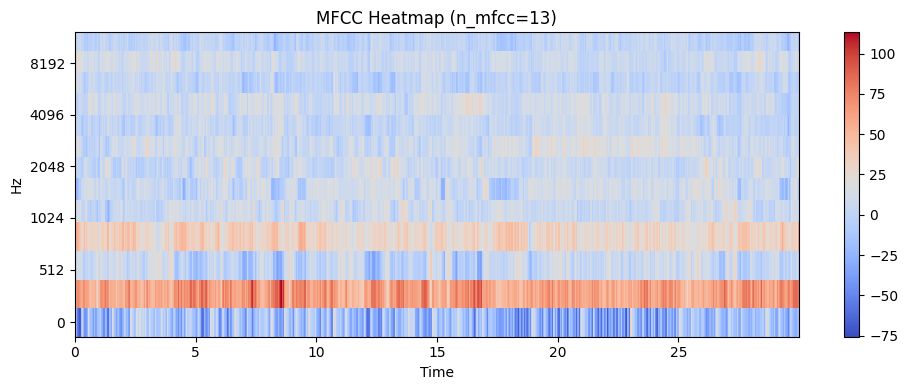

In [12]:
## --- MFCC --- #
# We typically use a small number of coefficients (e.g., 13 or 20):
n_mfcc = 13
# librosa.feature.mfcc automatically applies the log-Mel scaling and DCT
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

# Normalize the MFCCs for better visualization (often by subtracting the mean)
# mfccs -= np.mean(mfccs, axis=1, keepdims=True) # Optional normalization

## --- Plotting the MFCC Heatmap ---
plt.figure(figsize=(10, 4))
# librosa.display.specshow is also used here, but with different parameters
librosa.display.specshow(
    mfccs,
    sr=sr,
    x_axis='time',
    y_axis='mel' # 'mel' is common for MFCC visualization
)
# Note: For MFCCs, a different colormap (e.g., 'viridis') and a title with the number of coefficients are helpful.
plt.colorbar()
plt.title(f"MFCC Heatmap (n_mfcc={n_mfcc})")
plt.tight_layout()
plt.show()

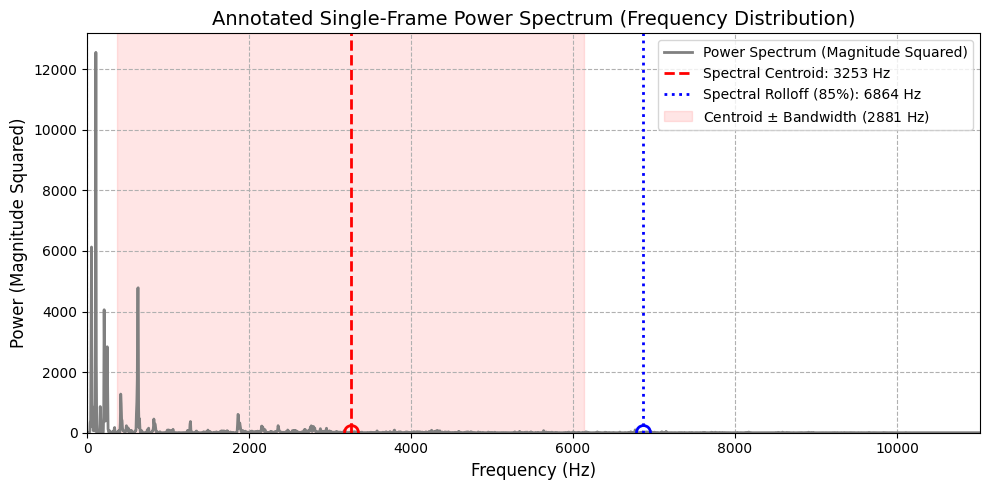

In [13]:
# Spectral Feature:

# Assuming y (audio data) and sr (sampling rate) are already loaded
# For a clear illustration, we'll take a short 4096-sample segment
n_fft = 4096 
hop_length = n_fft // 4 

# Compute the Short-Time Fourier Transform (STFT)
S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

# Convert to Power Spectrogram (S**2) and then to Decibels
S_power = S**2
S_db = librosa.power_to_db(S_power, ref=np.max)

# Select a single frame for the static spectrum plot (e.g., the 50th frame)
frame_index = S.shape[1] // 2 # Choose a frame in the middle of the audio
spectrum_frame = S_power[:, frame_index]

# Get the frequencies corresponding to the FFT bins
fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

#  Calculating Spectral Features for the Single Frame ---
# Spectral Centroid (Centroid is returned per frame, so we take one)
# Formula: Sum(S[k,t] * freq[k]) / Sum(S[j,t])
centroid_all = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
centroid_freq = centroid_all[0, frame_index]

# Spectral Rolloff (Frequency below which 85% of the power is concentrated)
rolloff_all = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, roll_percent=0.85)
rolloff_freq = rolloff_all[0, frame_index]

# Spectral Bandwidth (The standard deviation around the centroid)
# Note: Bandwidth is not a single point, but a spread, which can be visualized
bandwidth_all = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
bandwidth_val = bandwidth_all[0, frame_index]

# --- Plotting the Annotated Frequency Spectrum (Power Spectral Density) ---

plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, spectrum_frame, label='Power Spectrum (Magnitude Squared)', color='gray', linewidth=2)

# Highlight Spectral Centroid
plt.axvline(centroid_freq, color='r', linestyle='--', linewidth=2, 
            label=f'Spectral Centroid: {centroid_freq:.0f} Hz')
plt.plot(centroid_freq, spectrum_frame[np.argmin(np.abs(fft_freqs - centroid_freq))], 'ro', 
         markersize=10, markeredgewidth=2, fillstyle='none') # Annotation dot

# Highlight Spectral Rolloff
plt.axvline(rolloff_freq, color='b', linestyle=':', linewidth=2, 
            label=f'Spectral Rolloff (85%): {rolloff_freq:.0f} Hz')
plt.plot(rolloff_freq, spectrum_frame[np.argmin(np.abs(fft_freqs - rolloff_freq))], 'bo', 
         markersize=10, markeredgewidth=2, fillstyle='none') # Annotation dot

# Note: This is an approximation for static plot visualization
plt.axvspan(centroid_freq - bandwidth_val, centroid_freq + bandwidth_val, 
            color='r', alpha=0.1, label=f'Centroid $\\pm$ Bandwidth ({bandwidth_val:.0f} Hz)')

plt.title("Annotated Single-Frame Power Spectrum (Frequency Distribution)", fontsize=14)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Power (Magnitude Squared)", fontsize=12)
plt.xlim(0, sr / 2) # Limit x-axis to Nyquist frequency
plt.ylim(0)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

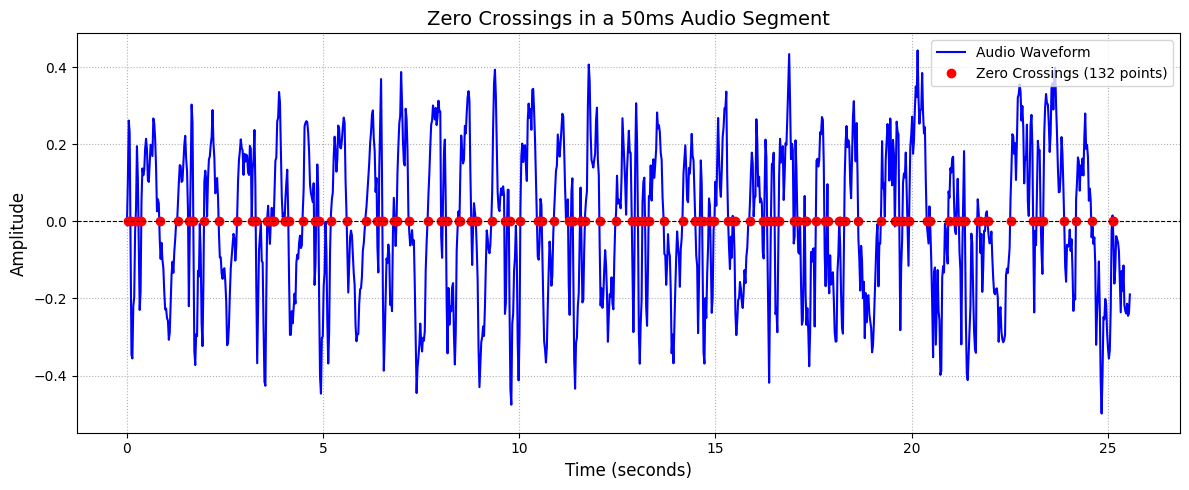

In [14]:
# Zero Cross Cutting Feature:

duration_ms = 50 # 50 milliseconds for a clear visual
segment_length = int(sr * duration_ms / 1000)
# Use a short segment from the start of the audio
start_sample = 0
end_sample = start_sample + segment_length

y_segment = y[start_sample:end_sample]
time_segment = librosa.frames_to_time(np.arange(len(y_segment)), sr=sr)


# --- Calculate the Zero Crossings ---

# The librosa ZCR function returns the RATE per frame, but for the visual
# we need the exact indices where the crossing happens.
# A zero crossing occurs when: y[n] * y[n-1] < 0

# Find the indices where the sign changes
zero_cross_indices = np.nonzero(
    np.diff(np.sign(y_segment))
)[0]

# Calculate the actual ZCR for this segment (optional, but good for context)
# ZCR = (Number of Zero Crossings) / (Length of the segment in samples)
zcr_value = len(zero_cross_indices) / len(y_segment)

# --- Plot the Waveform and Zero Crossings ---

plt.figure(figsize=(12, 5))

# Plot the waveform (Signal Amplitude vs. Time)
plt.plot(time_segment, y_segment, label='Audio Waveform', color='blue', linewidth=1.5)

# Marking the zero-crossing points (red dots on the x-axis)
# The y-value at a zero-crossing index is close to zero.
# We plot the index plus 1 since the crossing is between index[n] and index[n+1]
plt.plot(
    time_segment[zero_cross_indices + 1],
    np.zeros_like(zero_cross_indices + 1, dtype=float),
    'ro', # Red circle marker
    markersize=6,
    label=f'Zero Crossings ({len(zero_cross_indices)} points)'
)

# Plot the zero-amplitude line for reference
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.title(f"Zero Crossings in a {duration_ms}ms Audio Segment", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.grid(True, linestyle=':')
plt.legend(loc='upper right')
plt.ylim(np.min(y_segment) * 1.1, np.max(y_segment) * 1.1) # Add padding to y-axis
plt.tight_layout()
plt.show()

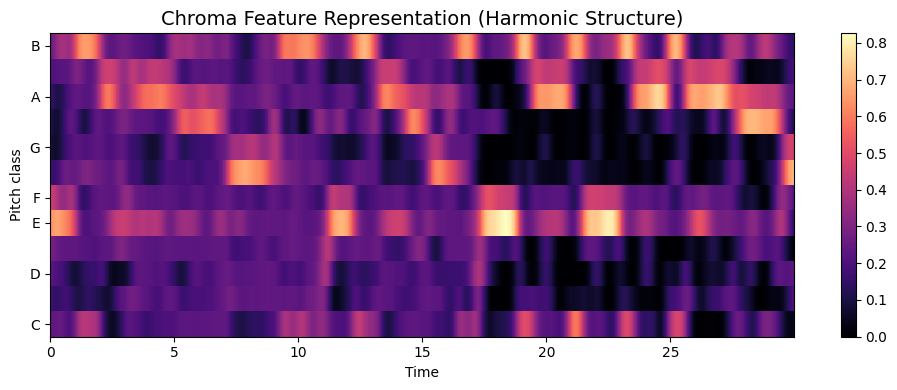

In [15]:
# Chroma Feature:

# Use CQT-based chroma for better frequency resolution at low frequencies
chroma = librosa.feature.chroma_cens(y=y, sr=sr)
# chroma will have a shape of (12, N_frames)

# --- Plotting the Chroma Feature Heatmap ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    chroma, 
    y_axis='chroma', 
    x_axis='time', 
    sr=sr,
    cmap='magma' # A good colormap for chroma visualization
)
plt.colorbar()
plt.title("Chroma Feature Representation (Harmonic Structure)", fontsize=14)
plt.tight_layout()
plt.show()

TypeError: unsupported format string passed to numpy.ndarray.__format__

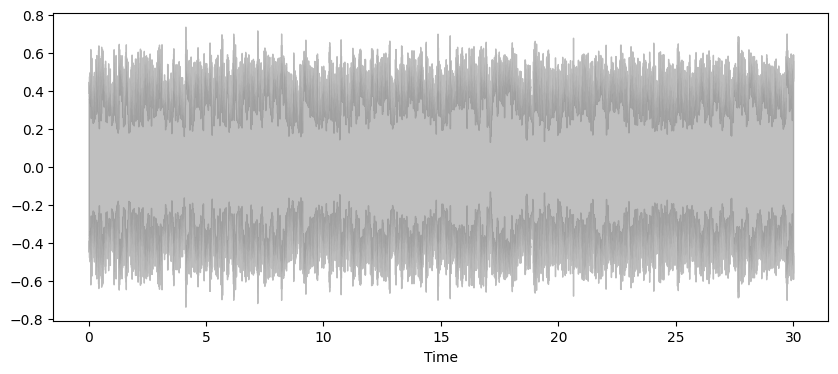

In [16]:
# Tempo Features
# Compute the tempo (BPM) and the frames corresponding to the beats
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

# Convert beat frames to time (seconds)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

# --- 4. Plot the Waveform with Beat Markers ---
plt.figure(figsize=(10, 4))

# Plot the waveform
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='gray')

# Overlay the beat times as vertical lines
plt.vlines(
    beat_times, 
    # Using the max/min amplitude of the waveform for the line extent
    ymin=np.min(y) * 1.05, 
    ymax=np.max(y) * 1.05, 
    color='red', 
    linestyle='--', 
    linewidth=1.5,
    alpha=0.7,
    label=f'Beats ({tempo:.2f} BPM)'
)

plt.title(f"Waveform with Detected Beats (Tempo: {tempo:.2f} BPM)", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Data Modelling 

In [6]:
# Separate features and labels
X = df.drop(columns=["label", "filename"])
y = df["label"]


## Data Splitting

In [7]:
# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Second split: Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


# Feature Standardization

In [8]:
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Use same scaler for validation and test
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


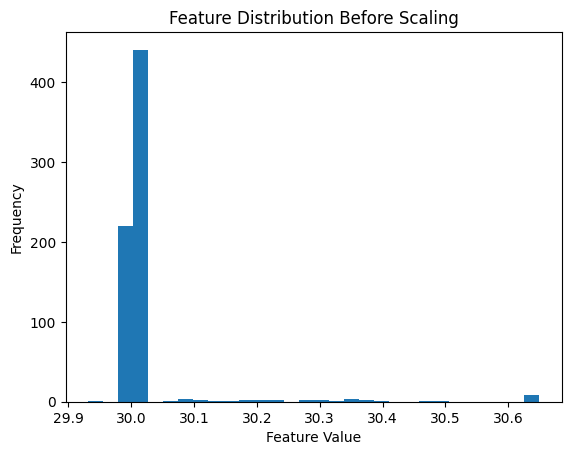

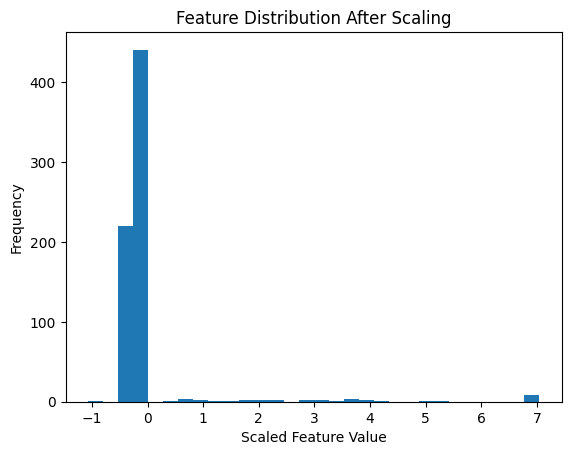

In [9]:
plt.figure()
plt.hist(X_train.iloc[:, 0], bins=30)
plt.title("Feature Distribution Before Scaling")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(X_train_scaled[:, 0], bins=30)
plt.title("Feature Distribution After Scaling")
plt.xlabel("Scaled Feature Value")
plt.ylabel("Frequency")
plt.show()


## PCA

In [10]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)


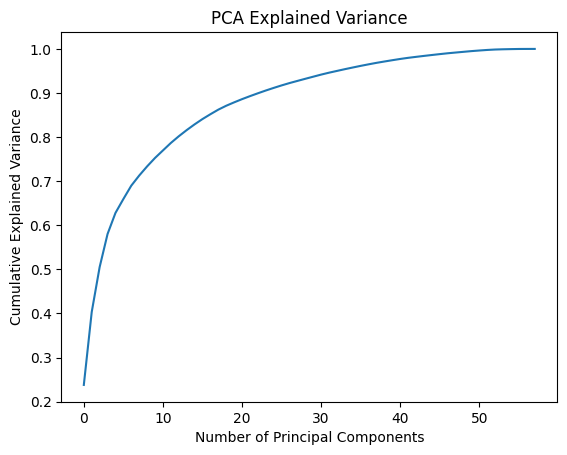

In [11]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


In [12]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Number of PCA components selected:", pca.n_components_)


Number of PCA components selected: 33


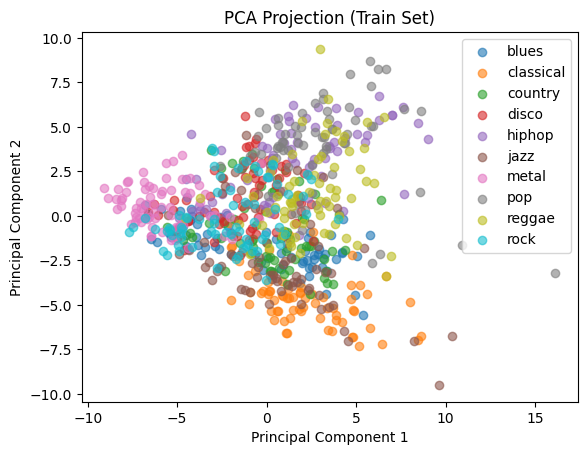

In [13]:
pca_2d = PCA(n_components=2)

X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure()
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(
        X_train_pca_2d[idx, 0],
        X_train_pca_2d[idx, 1],
        label=label,
        alpha=0.6
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection (Train Set)")
plt.legend()
plt.show()


In [14]:
# Final datasets to use in models
X_train_final = X_train_pca
X_val_final   = X_val_pca
X_test_final  = X_test_pca


## KNN

In [55]:
#KNN:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [56]:
le = LabelEncoder()

# Fit encoder on training labels only
y_train_enc = le.fit_transform(y_train)

# Transform validation and test labels
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

In [57]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_final, y_train_enc)
y_val_pred_enc = knn.predict(X_val_final)

# Convert predictions back to original labels
y_val_pred = le.inverse_transform(y_val_pred_enc)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

       blues       0.89      0.53      0.67        15
   classical       0.75      1.00      0.86        15
     country       0.55      0.80      0.65        15
       disco       0.47      0.47      0.47        15
      hiphop       0.62      0.67      0.65        15
        jazz       0.70      0.47      0.56        15
       metal       0.85      0.73      0.79        15
         pop       0.75      0.80      0.77        15
      reggae       0.42      0.33      0.37        15
        rock       0.47      0.53      0.50        15

    accuracy                           0.63       150
   macro avg       0.65      0.63      0.63       150
weighted avg       0.65      0.63      0.63       150



In [58]:
from sklearn.model_selection import GridSearchCV
# HyperParameter Tuning KNN:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_final, y_train_enc)
print("Best KNN Parameters:", grid_search.best_params_)

Best KNN Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [59]:
best_knn = grid_search.best_estimator_

y_val_pred_enc = best_knn.predict(X_val_final)
y_val_pred = le.inverse_transform(y_val_pred_enc)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.64
              precision    recall  f1-score   support

       blues       1.00      0.53      0.70        15
   classical       0.83      1.00      0.91        15
     country       0.71      0.80      0.75        15
       disco       0.38      0.40      0.39        15
      hiphop       0.69      0.60      0.64        15
        jazz       0.75      0.40      0.52        15
       metal       0.79      0.73      0.76        15
         pop       0.57      0.80      0.67        15
      reggae       0.53      0.53      0.53        15
        rock       0.45      0.60      0.51        15

    accuracy                           0.64       150
   macro avg       0.67      0.64      0.64       150
weighted avg       0.67      0.64      0.64       150



In [60]:
# Test Accuracy for best_knn:
# Predict on test set using best kNN model
y_test_pred_enc = best_knn.predict(X_test_final)

# Convert encoded labels back to original genre names
y_test_pred_knn = le.inverse_transform(y_test_pred_enc)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_knn))
print(classification_report(y_test, y_test_pred_knn))

Test Accuracy: 0.6133333333333333
              precision    recall  f1-score   support

       blues       0.62      0.53      0.57        15
   classical       0.86      0.80      0.83        15
     country       0.63      0.80      0.71        15
       disco       0.46      0.40      0.43        15
      hiphop       0.78      0.47      0.58        15
        jazz       0.58      0.47      0.52        15
       metal       0.85      0.73      0.79        15
         pop       0.75      0.80      0.77        15
      reggae       0.53      0.60      0.56        15
        rock       0.33      0.53      0.41        15

    accuracy                           0.61       150
   macro avg       0.64      0.61      0.62       150
weighted avg       0.64      0.61      0.62       150



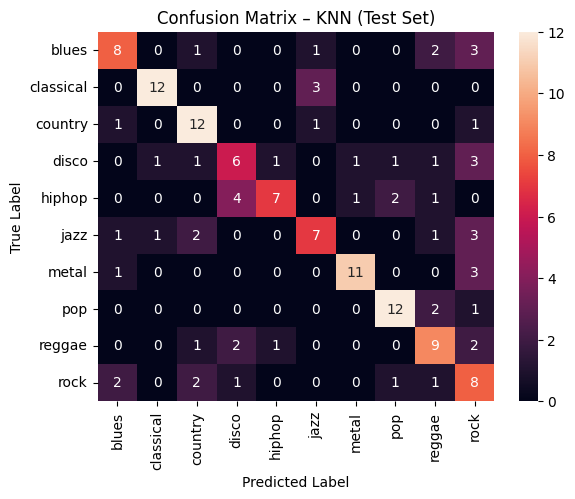

In [61]:
cm = confusion_matrix(y_test, y_test_pred_knn)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – KNN (Test Set)")
plt.show()

## Logistic Regression

In [62]:
## Logistic Regression:
from sklearn.linear_model import LogisticRegression

In [63]:
#Logistic Regression in scikit-learn requires numeric class labels.
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)


In [64]:
# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, multi_class = 'auto', random_state=42)

In [65]:
log_reg.fit(X_train_final, y_train_enc)


C:\Users\Aman\.conda\envs\mllab\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto', random_state=42)

In [66]:
# Validation Accuracy
y_val_pred_enc = log_reg.predict(X_val_final)
y_val_pred = le.inverse_transform(y_val_pred_enc)

In [67]:
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7733333333333333
              precision    recall  f1-score   support

       blues       0.90      0.60      0.72        15
   classical       1.00      0.93      0.97        15
     country       0.86      0.80      0.83        15
       disco       0.50      0.60      0.55        15
      hiphop       0.85      0.73      0.79        15
        jazz       0.83      1.00      0.91        15
       metal       0.76      0.87      0.81        15
         pop       0.87      0.87      0.87        15
      reggae       0.71      0.80      0.75        15
        rock       0.57      0.53      0.55        15

    accuracy                           0.77       150
   macro avg       0.78      0.77      0.77       150
weighted avg       0.78      0.77      0.77       150



In [68]:
# Log_reg Hyper Parameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_final, y_train_enc)
print("Best Logistic Regression Parameters:", grid_search.best_params_)


Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\Aman\.conda\envs\mllab\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [69]:
best_log_reg = grid_search.best_estimator_

# Validation Accuracy of best log_reg
y_val_pred_enc = best_log_reg.predict(X_val_final)
y_val_pred = le.inverse_transform(y_val_pred_enc)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7866666666666666
              precision    recall  f1-score   support

       blues       0.90      0.60      0.72        15
   classical       1.00      0.93      0.97        15
     country       0.86      0.80      0.83        15
       disco       0.57      0.53      0.55        15
      hiphop       0.69      0.73      0.71        15
        jazz       0.83      1.00      0.91        15
       metal       0.87      0.87      0.87        15
         pop       0.78      0.93      0.85        15
      reggae       0.71      0.80      0.75        15
        rock       0.71      0.67      0.69        15

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.78       150
weighted avg       0.79      0.79      0.78       150



In [70]:
# Test Accuracy of best log_reg
y_test_pred_enc = best_log_reg.predict(X_test_final)
y_test_pred_logreg = le.inverse_transform(y_test_pred_enc)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_logreg))
print(classification_report(y_test, y_test_pred_logreg))

Test Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

       blues       0.50      0.60      0.55        15
   classical       0.91      0.67      0.77        15
     country       0.79      0.73      0.76        15
       disco       0.62      0.33      0.43        15
      hiphop       0.50      0.47      0.48        15
        jazz       0.64      0.93      0.76        15
       metal       0.85      0.73      0.79        15
         pop       0.88      0.93      0.90        15
      reggae       0.55      0.73      0.63        15
        rock       0.57      0.53      0.55        15

    accuracy                           0.67       150
   macro avg       0.68      0.67      0.66       150
weighted avg       0.68      0.67      0.66       150



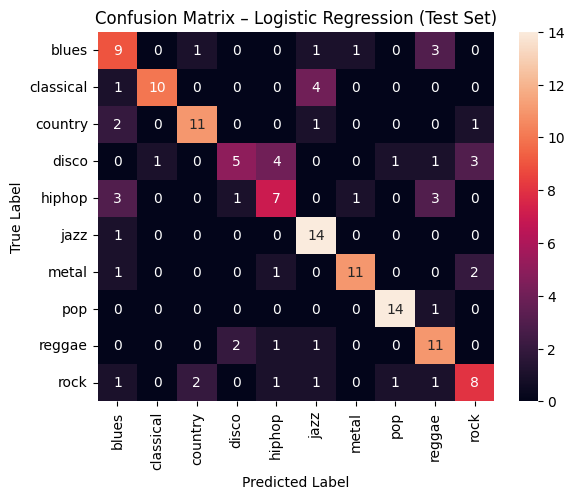

In [71]:
cm = confusion_matrix(y_test, y_test_pred_logreg)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression (Test Set)")
plt.show()

##  Decision Trees

In [72]:
from sklearn.tree import DecisionTreeClassifier

In [73]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [74]:
# Baselin DT:
dt = DecisionTreeClassifier(
    random_state=42
)

dt.fit(X_train_final, y_train_enc)

DecisionTreeClassifier(random_state=42)

In [75]:
y_val_pred_enc = dt.predict(X_val_final)
y_val_pred = le.inverse_transform(y_val_pred_enc)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.49333333333333335
              precision    recall  f1-score   support

       blues       0.67      0.40      0.50        15
   classical       0.86      0.80      0.83        15
     country       0.40      0.53      0.46        15
       disco       0.38      0.40      0.39        15
      hiphop       0.39      0.47      0.42        15
        jazz       0.69      0.73      0.71        15
       metal       0.42      0.53      0.47        15
         pop       0.54      0.47      0.50        15
      reggae       0.50      0.47      0.48        15
        rock       0.18      0.13      0.15        15

    accuracy                           0.49       150
   macro avg       0.50      0.49      0.49       150
weighted avg       0.50      0.49      0.49       150



In [76]:
# Hyper Parameter Tuning for DT
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [77]:
grid_search.fit(X_train_final, y_train_enc)
print("Best Decision Tree Parameters:", grid_search.best_params_)


Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [78]:
best_dt = grid_search.best_estimator_

y_val_pred_enc = best_dt.predict(X_val_final)
y_val_pred = le.inverse_transform(y_val_pred_enc)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.4666666666666667
              precision    recall  f1-score   support

       blues       0.75      0.40      0.52        15
   classical       0.86      0.80      0.83        15
     country       0.33      0.60      0.43        15
       disco       0.39      0.47      0.42        15
      hiphop       0.26      0.33      0.29        15
        jazz       0.53      0.53      0.53        15
       metal       0.62      0.53      0.57        15
         pop       0.70      0.47      0.56        15
      reggae       0.38      0.20      0.26        15
        rock       0.28      0.33      0.30        15

    accuracy                           0.47       150
   macro avg       0.51      0.47      0.47       150
weighted avg       0.51      0.47      0.47       150



In [79]:
# Predict on test set using Best DT Model:
y_test_pred_enc = best_dt.predict(X_test_final)
y_test_pred_dt = le.inverse_transform(y_test_pred_enc)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_dt))
print(classification_report(y_test, y_test_pred_dt))

Test Accuracy: 0.4066666666666667
              precision    recall  f1-score   support

       blues       0.50      0.40      0.44        15
   classical       0.67      0.67      0.67        15
     country       0.14      0.13      0.14        15
       disco       0.20      0.20      0.20        15
      hiphop       0.21      0.27      0.24        15
        jazz       0.45      0.33      0.38        15
       metal       0.67      0.53      0.59        15
         pop       0.56      0.67      0.61        15
      reggae       0.64      0.47      0.54        15
        rock       0.26      0.40      0.32        15

    accuracy                           0.41       150
   macro avg       0.43      0.41      0.41       150
weighted avg       0.43      0.41      0.41       150



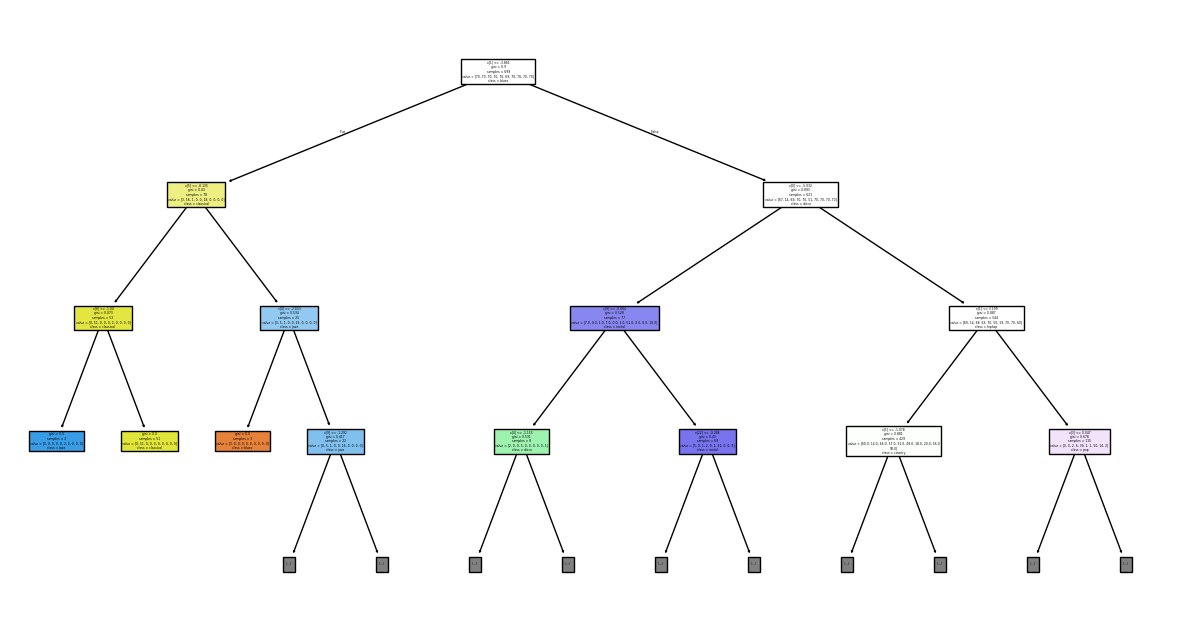

In [80]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 8))
plot_tree(
    best_dt,
    max_depth=3,
    class_names=le.classes_,
    filled=True
)
plt.show()

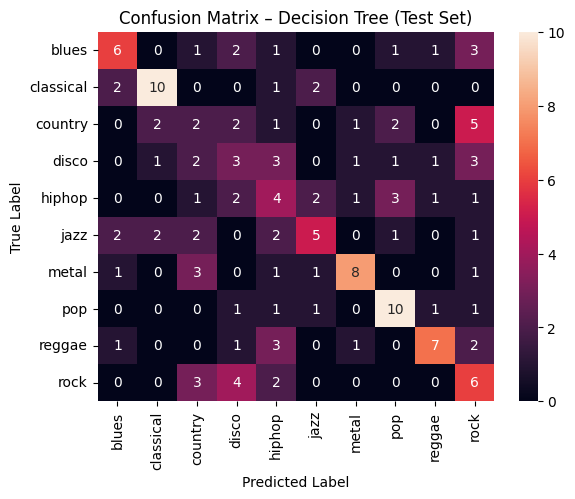

In [81]:
cm = confusion_matrix(y_test, y_test_pred_dt)

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Decision Tree (Test Set)")
plt.show()

## Comparing KNN, Logistic Regression and Decision Trees:

In [82]:
def evaluate_model(model, model_name, X_val, y_val, X_test, y_test, label_encoder):
    """
    Evaluate a trained classification model on validation and test datasets.

    Parameters
    ----------
    model : object
        Trained classification model with a `predict` method.
    model_name : str
        Name of the model (used for display purposes).
    X_val : array-like
        Feature matrix for the validation dataset.
    y_val : array-like
        True labels for the validation dataset (original label format).
    X_test : array-like
        Feature matrix for the test dataset.
    y_test : array-like
        True labels for the test dataset (original label format).
    label_encoder : object
        Fitted label encoder used to inverse-transform predicted labels.

    Returns
    -------
    None
        Just Prints validation and test accuracy scores and classification reports.
    """
    print("=" * 60)
    print(f"Model: {model_name}")
    print("=" * 60)

    # Validation performance
    y_val_pred_enc = model.predict(X_val)
    y_val_pred = label_encoder.inverse_transform(y_val_pred_enc)
    val_acc = accuracy_score(y_val, y_val_pred)

    print("Validation Accuracy:", val_acc)
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Test performance
    y_test_pred_enc = model.predict(X_test)
    y_test_pred = label_encoder.inverse_transform(y_test_pred_enc)
    test_acc = accuracy_score(y_test, y_test_pred)

    print("Test Accuracy:", test_acc)
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))


In [83]:
evaluate_model(
    model=best_knn,
    model_name="k-Nearest Neighbors",
    X_val=X_val_final,
    y_val=y_val,
    X_test=X_test_final,
    y_test=y_test,
    label_encoder=le
)

evaluate_model(
    model=best_log_reg,
    model_name="Logistic Regression",
    X_val=X_val_final,
    y_val=y_val,
    X_test=X_test_final,
    y_test=y_test,
    label_encoder=le
)

evaluate_model(
    model=best_dt,
    model_name="Decision Tree",
    X_val=X_val_final,
    y_val=y_val,
    X_test=X_test_final,
    y_test=y_test,
    label_encoder=le
)

Model: k-Nearest Neighbors
Validation Accuracy: 0.64
Validation Classification Report:
              precision    recall  f1-score   support

       blues       1.00      0.53      0.70        15
   classical       0.83      1.00      0.91        15
     country       0.71      0.80      0.75        15
       disco       0.38      0.40      0.39        15
      hiphop       0.69      0.60      0.64        15
        jazz       0.75      0.40      0.52        15
       metal       0.79      0.73      0.76        15
         pop       0.57      0.80      0.67        15
      reggae       0.53      0.53      0.53        15
        rock       0.45      0.60      0.51        15

    accuracy                           0.64       150
   macro avg       0.67      0.64      0.64       150
weighted avg       0.67      0.64      0.64       150

Test Accuracy: 0.6133333333333333
Test Classification Report:
              precision    recall  f1-score   support

       blues       0.62      0.53    

## Feature Importance:

In [84]:
# Using Decision Trees:
# Get feature importance scores
importances = best_dt.feature_importances_

pca_feature_names = [f"PC{i+1}" for i in range(len(importances))]

feature_importance_df = pd.DataFrame({
    "Feature": pca_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)



In [85]:
print(feature_importance_df.head(10))


   Feature  Importance
1      PC2    0.207492
0      PC1    0.117855
3      PC4    0.078894
4      PC5    0.053840
14    PC15    0.047932
5      PC6    0.046456
8      PC9    0.039009
9     PC10    0.035736
23    PC24    0.032159
7      PC8    0.030646


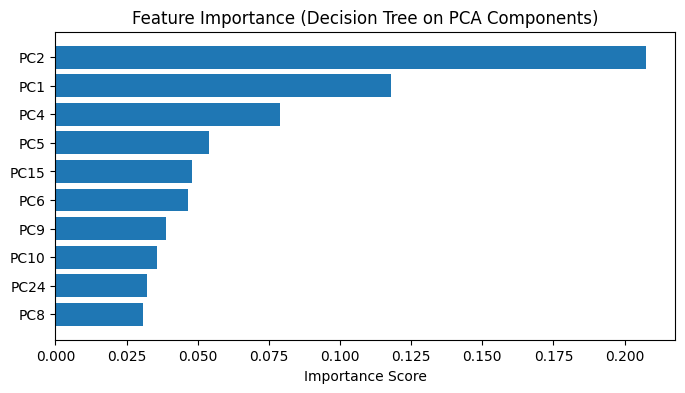

In [86]:
plt.figure(figsize=(8, 4))
plt.barh(
    feature_importance_df["Feature"][:10],
    feature_importance_df["Importance"][:10]
)
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Feature Importance (Decision Tree on PCA Components)")
plt.show()


## Genre Wise Analysis: Model Comparison

In [100]:
report_knn = classification_report(y_test, y_test_pred_knn, output_dict=True)
report_lr  = classification_report(y_test, y_test_pred_logreg,  output_dict=True)
report_dt  = classification_report(y_test, y_test_pred_dt,  output_dict=True)


In [101]:
genres = list(report_knn.keys())[:-3]  # remove accuracy, macro avg, weighted avg


In [106]:
# F1 Score
genre_f1_df = pd.DataFrame({
    "Genre": genres,
    "kNN": [report_knn[g]["f1-score"] for g in genres],
    "Logistic Regression": [report_lr[g]["f1-score"] for g in genres],
    "Decision Tree": [report_dt[g]["f1-score"] for g in genres]
})

print(genre_f1_df)


       Genre       kNN  Logistic Regression  Decision Tree
0      blues  0.571429             0.545455       0.444444
1  classical  0.827586             0.769231       0.666667
2    country  0.705882             0.758621       0.137931
3      disco  0.428571             0.434783       0.200000
4     hiphop  0.583333             0.482759       0.235294
5       jazz  0.518519             0.756757       0.384615
6      metal  0.785714             0.785714       0.592593
7        pop  0.774194             0.903226       0.606061
8     reggae  0.562500             0.628571       0.538462
9       rock  0.410256             0.551724       0.315789


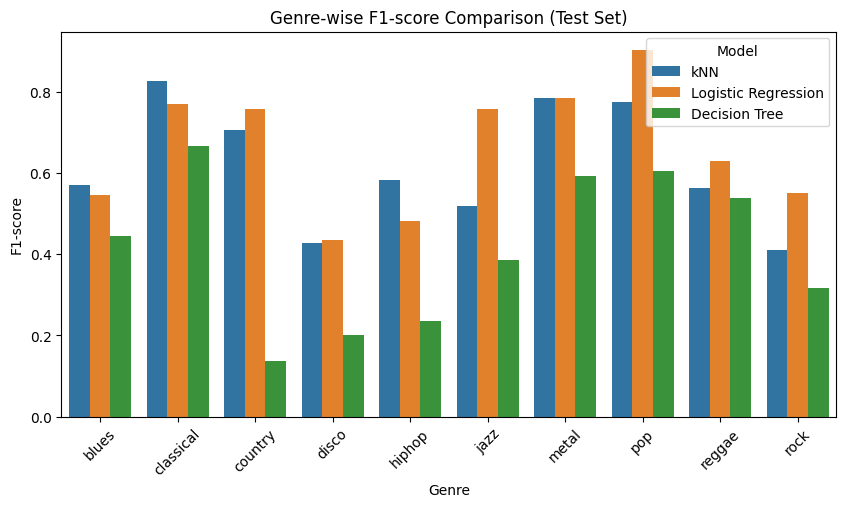

In [107]:
genre_f1_melted = genre_f1_df.melt(
    id_vars="Genre",
    var_name="Model",
    value_name="F1-score"
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=genre_f1_melted,
    x="Genre",
    y="F1-score",
    hue="Model"
)
plt.xticks(rotation=45)
plt.title("Genre-wise F1-score Comparison (Test Set)")
plt.ylabel("F1-score")
plt.show()


In [112]:
#RECALL:
genre_recall_df = pd.DataFrame({
    "Genre": genres,
    "kNN": [report_knn[g]["recall"] for g in genres],
    "Logistic Regression": [report_lr[g]["recall"] for g in genres],
    "Decision Tree": [report_dt[g]["recall"] for g in genres]
})

print(genre_recall_df)

       Genre       kNN  Logistic Regression  Decision Tree
0      blues  0.533333             0.600000       0.400000
1  classical  0.800000             0.666667       0.666667
2    country  0.800000             0.733333       0.133333
3      disco  0.400000             0.333333       0.200000
4     hiphop  0.466667             0.466667       0.266667
5       jazz  0.466667             0.933333       0.333333
6      metal  0.733333             0.733333       0.533333
7        pop  0.800000             0.933333       0.666667
8     reggae  0.600000             0.733333       0.466667
9       rock  0.533333             0.533333       0.400000


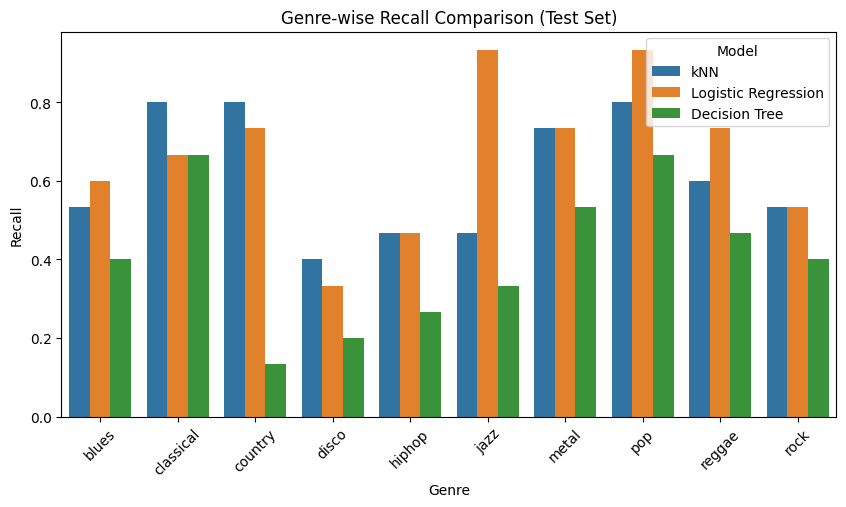

In [115]:
genre_f1_melted = genre_recall_df.melt(
    id_vars="Genre",
    var_name="Model",
    value_name="Recall"
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=genre_f1_melted,
    x="Genre",
    y="Recall",
    hue="Model"
)
plt.xticks(rotation=45)
plt.title("Genre-wise Recall Comparison (Test Set)")
plt.ylabel("Recall")
plt.show()


In [116]:
# PRECISION:
genre_precision_df = pd.DataFrame({
    "Genre": genres,
    "kNN": [report_knn[g]["precision"] for g in genres],
    "Logistic Regression": [report_lr[g]["precision"] for g in genres],
    "Decision Tree": [report_dt[g]["precision"] for g in genres]
})

print(genre_precision_df)

       Genre       kNN  Logistic Regression  Decision Tree
0      blues  0.615385             0.500000       0.500000
1  classical  0.857143             0.909091       0.666667
2    country  0.631579             0.785714       0.142857
3      disco  0.461538             0.625000       0.200000
4     hiphop  0.777778             0.500000       0.210526
5       jazz  0.583333             0.636364       0.454545
6      metal  0.846154             0.846154       0.666667
7        pop  0.750000             0.875000       0.555556
8     reggae  0.529412             0.550000       0.636364
9       rock  0.333333             0.571429       0.260870


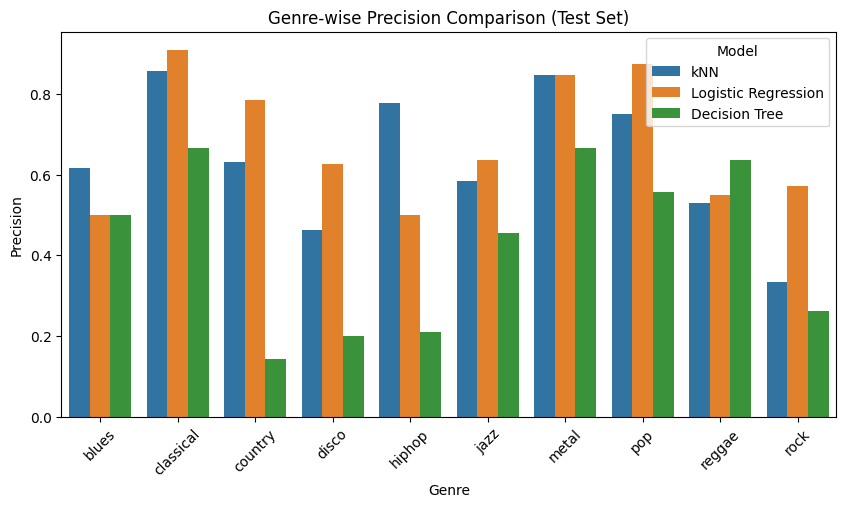

In [117]:
genre_f1_melted = genre_precision_df.melt(
    id_vars="Genre",
    var_name="Model",
    value_name="Precision"
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=genre_f1_melted,
    x="Genre",
    y="Precision",
    hue="Model"
)
plt.xticks(rotation=45)
plt.title("Genre-wise Precision Comparison (Test Set)")
plt.ylabel("Precision")
plt.show()

In [118]:
# Confusion Pair
cm = confusion_matrix(y_test, y_test_pred_knn, labels=le.classes_)

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Remove diagonal (correct predictions)
np.fill_diagonal(cm_df.values, 0)

# Find top confusion pairs
confusion_pairs = cm_df.stack().sort_values(ascending=False).head(10)

print(confusion_pairs)

hiphop     disco      4
blues      rock       3
metal      rock       3
classical  jazz       3
disco      rock       3
jazz       rock       3
           country    2
reggae     disco      2
blues      reggae     2
hiphop     pop        2
dtype: int64


In [64]:
# Saving best models:
import joblib

# Save best models
joblib.dump(best_knn, "best_knn_model.pkl")
joblib.dump(best_rf, "best_rf_model.pkl")
joblib.dump(best_logreg, "best_logreg_model.pkl")

joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder_rf.pkl")

print("Saved best Models!")


Saved best Models!


######## --------- End Of Project -------------------#########